# Differential expression on C. elegans data

This notebook was contributed by Eduardo Beltrame [@Munfred](https://github.com/Munfred) and edited by Romain Lopez, Adam Gayoso, and Pierre Boyeau.

Processing and visualizing 89k cells from Packer et al. 2019 C. elegans 10xv2 single cell data

Original article:
`A lineage-resolved molecular atlas of C. elegans embryogenesis at single-cell resolution`

https://science.sciencemag.org/content/365/6459/eaax1971.long

The anndata object we provide  has 89,701 cells and 20,222 genes.
It includes short gene descriptions from [WormBase](https://wormbase.org) that will show up when mousing over the interactive plots.

**Steps performed**:

1. Loading the data from anndata containing cell labels and gene descriptions
1. Training the model with batch labels for integration with scVI
1. Retrieving the scVI latent space and imputed values
1. Visualize the latent space with an interactive t-SNE plot using Plotly
1. Perform differential expression and visualize with interactive volcano plot and heatmap using Plotly

This notebook was designed to be run in Google Colab.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/env/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as p9
import scanpy as sc
import scvi
import seaborn as sns
import torch

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.0


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [5]:
adata_path = os.path.join(save_dir.name, "packer2019.h5ad")

adata = sc.read(
    adata_path,
    backup_url="https://github.com/Munfred/wormcells-site/releases/download/packer2019/packer2019.h5ad",
)
adata

  0%|          | 0.00/653M [00:00<?, ?B/s]

/env/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.


AnnData object with n_obs × n_vars = 89701 × 20222
    obs: 'cell', 'numi', 'time_point', 'batch', 'size_factor', 'cell_type', 'cell_subtype', 'plot_cell_type', 'raw_embryo_time', 'embryo_time', 'embryo_time_bin', 'raw_embryo_time_bin', 'lineage', 'passed_qc'
    var: 'gene_id', 'gene_name', 'gene_description'

### Take a look at the gene descriptions

The gene descriptions were taken using the [WormBase API](https://wormbase.org/about/userguide/for_developers#3--10).

In [6]:
display(
    adata.var.head().style.set_properties(
        subset=["gene_description"], **{"width": "600px"}
    )
)

,gene_id,gene_name,gene_description
index,,,
WBGene00010957,WBGene00010957,nduo-6,Is affected by several genes including daf-16; daf-12; and hsf-1 based on RNA-seq and tiling array studies. Is affected by six chemicals including Rotenone; Psoralens; and metformin based on RNA-seq and microarray studies.
WBGene00010958,WBGene00010958,ndfl-4,Is enriched in Psub2 based on RNA-seq studies. Is affected by several genes including daf-16; daf-12; and clk-1 based on RNA-seq and microarray studies. Is affected by six chemicals including Alovudine; Psoralens; and metformin based on RNA-seq studies.
WBGene00010959,WBGene00010959,nduo-1,Is an ortholog of human MT-ND1 (mitochondrially encoded NADH:ubiquinone oxidoreductase core subunit 1). Is predicted to contribute to NADH dehydrogenase activity. Human ortholog(s) of this gene are implicated in Leber hereditary optic neuropathy and MELAS syndrome.
WBGene00010960,WBGene00010960,atp-6,"Is predicted to contribute to proton-transporting ATP synthase activity, rotational mechanism."
WBGene00010961,WBGene00010961,nduo-2,Is affected by several genes including hsf-1; clk-1; and elt-2 based on RNA-seq and microarray studies. Is affected by eight chemicals including stavudine; Zidovudine; and Psoralens based on RNA-seq and microarray studies.


### Selecting genes and loading data

We use the utility `scvi.data.poisson_gene_selection` to select genes according to their dropout rate, which is a simple and scalable approach to select genes.

This method was described by Andrews & Hemberg in the article `M3Drop: dropout-based feature selection for scRNASeq `:
https://academic.oup.com/bioinformatics/article/35/16/2865/5258099

This method modifies the adata to add the following fields:

```
highly_variable                   # boolean true for chosen genes
observed_fraction_zeros	       # fraction of observed zeros per gene
expected_fraction_zeros	       # expected fraction of observed zeros per gene
prob_zero_enriched_nbatches	   # If batch_key is given, this denotes in how many batches genes are detected as zero enriched
prob_zero_enrichment	          # Probability of zero enrichment, median across batches in the case of multiple batches
prob_zero_enrichment_rank         # Rank of the gene according to probability of zero enrichment
```

```{note}
Gene selection is an important step to obtain relevant cell representations with scVI.
Generally, selecting the top few thousands top-ranking genes predicted by a gene selection tool suffice to obtain good performance.

Increasing the number of selected genes may be required in some applications, e.g., to increase the number of considered genes for differential expression.
Note, however, that this will increase the time required to reach convergence and GPU memory load.
It may also require to tune scVI's model hyperparameters (see the autotune tutorial)

Alternatives to the Poisson gene selection can be used, e.g., via scanpy or seurat.
```

In [7]:
scvi.data.poisson_gene_selection(adata)
adata.var.head()

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



Sampling from binomial...:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling from binomial...:  22%|██▏       | 2233/10000 [00:00<00:00, 22324.27it/s]

Sampling from binomial...:  45%|████▍     | 4466/10000 [00:00<00:00, 20859.63it/s]

Sampling from binomial...:  66%|██████▌   | 6594/10000 [00:00<00:00, 21043.47it/s]

Sampling from binomial...:  87%|████████▋ | 8742/10000 [00:00<00:00, 21210.38it/s]

Sampling from binomial...: 100%|██████████| 10000/10000 [00:00<00:00, 21246.35it/s]

,gene_id,gene_name,gene_description,highly_variable,observed_fraction_zeros,expected_fraction_zeros,prob_zero_enriched_nbatches,prob_zero_enrichment,prob_zero_enrichment_rank
index,,,,,,,,,
WBGene00010957,WBGene00010957,nduo-6,Is affected by several genes including daf-16;...,False,0.075685,0.002028,0,0.0762,15661.0
WBGene00010958,WBGene00010958,ndfl-4,Is enriched in Psub2 based on RNA-seq studies....,True,0.659680,0.623356,1,0.2502,19567.0
WBGene00010959,WBGene00010959,nduo-1,Is an ortholog of human MT-ND1 (mitochondriall...,True,0.201993,0.046608,1,0.1886,18907.0
WBGene00010960,WBGene00010960,atp-6,Is predicted to contribute to proton-transport...,True,0.138081,0.001848,1,0.1381,17859.0
WBGene00010961,WBGene00010961,nduo-2,Is affected by several genes including hsf-1; ...,True,0.468434,0.383116,1,0.2860,19800.0


In [8]:
adata = adata[:, adata.var["highly_variable"]]  # focus on selected genes
adata.layers["counts"] = (
    adata.X.copy().tocsr()
)  # converts to CSR format, preserve counts

scvi.model.SCVI.setup_anndata(
    adata, layer="counts", batch_key="batch"
)  # prepare data for scVI

/tmp/ipykernel_157/2431530709.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



### Define and train the model

In [9]:
model = scvi.model.SCVI(
    adata, gene_likelihood="nb"
)  # We use Negative Binomial count likelihoods, following Boyeau et al., 2023.
model.train(
    check_val_every_n_epoch=1,
    max_epochs=400,
    early_stopping=True,
    early_stopping_patience=20,
    early_stopping_monitor="elbo_validation",
)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:03<24:06,  3.62s/it]

Epoch 1/400:   0%|          | 1/400 [00:03<24:06,  3.62s/it, v_num=1, train_loss_step=2.28e+3, train_loss_epoch=2.29e+3]

Epoch 2/400:   0%|          | 1/400 [00:03<24:06,  3.62s/it, v_num=1, train_loss_step=2.28e+3, train_loss_epoch=2.29e+3]

Epoch 2/400:   0%|          | 2/400 [00:06<22:04,  3.33s/it, v_num=1, train_loss_step=2.28e+3, train_loss_epoch=2.29e+3]

Epoch 2/400:   0%|          | 2/400 [00:06<22:04,  3.33s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.14e+3]

Epoch 3/400:   0%|          | 2/400 [00:06<22:04,  3.33s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.14e+3]

Epoch 3/400:   1%|          | 3/400 [00:09<21:11,  3.20s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.14e+3]

Epoch 3/400:   1%|          | 3/400 [00:09<21:11,  3.20s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.11e+3]

Epoch 4/400:   1%|          | 3/400 [00:09<21:11,  3.20s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.11e+3]

Epoch 4/400:   1%|          | 4/400 [00:12<20:39,  3.13s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.11e+3]

Epoch 4/400:   1%|          | 4/400 [00:12<20:39,  3.13s/it, v_num=1, train_loss_step=2.23e+3, train_loss_epoch=2.09e+3]

Epoch 5/400:   1%|          | 4/400 [00:12<20:39,  3.13s/it, v_num=1, train_loss_step=2.23e+3, train_loss_epoch=2.09e+3]

Epoch 5/400:   1%|▏         | 5/400 [00:15<20:22,  3.10s/it, v_num=1, train_loss_step=2.23e+3, train_loss_epoch=2.09e+3]

Epoch 5/400:   1%|▏         | 5/400 [00:15<20:22,  3.10s/it, v_num=1, train_loss_step=2.22e+3, train_loss_epoch=2.08e+3]

Epoch 6/400:   1%|▏         | 5/400 [00:15<20:22,  3.10s/it, v_num=1, train_loss_step=2.22e+3, train_loss_epoch=2.08e+3]

Epoch 6/400:   2%|▏         | 6/400 [00:18<20:11,  3.07s/it, v_num=1, train_loss_step=2.22e+3, train_loss_epoch=2.08e+3]

Epoch 6/400:   2%|▏         | 6/400 [00:18<20:11,  3.07s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.08e+3]

Epoch 7/400:   2%|▏         | 6/400 [00:18<20:11,  3.07s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.08e+3]

Epoch 7/400:   2%|▏         | 7/400 [00:21<20:02,  3.06s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.08e+3]

Epoch 7/400:   2%|▏         | 7/400 [00:21<20:02,  3.06s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.07e+3]

Epoch 8/400:   2%|▏         | 7/400 [00:21<20:02,  3.06s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.07e+3]

Epoch 8/400:   2%|▏         | 8/400 [00:24<19:55,  3.05s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.07e+3]

Epoch 8/400:   2%|▏         | 8/400 [00:24<19:55,  3.05s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.07e+3]

Epoch 9/400:   2%|▏         | 8/400 [00:24<19:55,  3.05s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.07e+3]

Epoch 9/400:   2%|▏         | 9/400 [00:27<19:50,  3.04s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.07e+3]

Epoch 9/400:   2%|▏         | 9/400 [00:27<19:50,  3.04s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.07e+3] 

Epoch 10/400:   2%|▏         | 9/400 [00:27<19:50,  3.04s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.07e+3]

Epoch 10/400:   2%|▎         | 10/400 [00:31<19:46,  3.04s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.07e+3]

Epoch 10/400:   2%|▎         | 10/400 [00:31<19:46,  3.04s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 11/400:   2%|▎         | 10/400 [00:31<19:46,  3.04s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 11/400:   3%|▎         | 11/400 [00:34<19:42,  3.04s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 11/400:   3%|▎         | 11/400 [00:34<19:42,  3.04s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=2.06e+3]

Epoch 12/400:   3%|▎         | 11/400 [00:34<19:42,  3.04s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=2.06e+3]

Epoch 12/400:   3%|▎         | 12/400 [00:37<19:38,  3.04s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=2.06e+3]

Epoch 12/400:   3%|▎         | 12/400 [00:37<19:38,  3.04s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 13/400:   3%|▎         | 12/400 [00:37<19:38,  3.04s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 13/400:   3%|▎         | 13/400 [00:40<19:34,  3.03s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 13/400:   3%|▎         | 13/400 [00:40<19:34,  3.03s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 14/400:   3%|▎         | 13/400 [00:40<19:34,  3.03s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 14/400:   4%|▎         | 14/400 [00:43<19:31,  3.03s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 14/400:   4%|▎         | 14/400 [00:43<19:31,  3.03s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 15/400:   4%|▎         | 14/400 [00:43<19:31,  3.03s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 15/400:   4%|▍         | 15/400 [00:46<19:28,  3.04s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 15/400:   4%|▍         | 15/400 [00:46<19:28,  3.04s/it, v_num=1, train_loss_step=2.22e+3, train_loss_epoch=2.06e+3]

Epoch 16/400:   4%|▍         | 15/400 [00:46<19:28,  3.04s/it, v_num=1, train_loss_step=2.22e+3, train_loss_epoch=2.06e+3]

Epoch 16/400:   4%|▍         | 16/400 [00:49<19:25,  3.03s/it, v_num=1, train_loss_step=2.22e+3, train_loss_epoch=2.06e+3]

Epoch 16/400:   4%|▍         | 16/400 [00:49<19:25,  3.03s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.06e+3]

Epoch 17/400:   4%|▍         | 16/400 [00:49<19:25,  3.03s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.06e+3]

Epoch 17/400:   4%|▍         | 17/400 [00:52<19:22,  3.03s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.06e+3]

Epoch 17/400:   4%|▍         | 17/400 [00:52<19:22,  3.03s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 18/400:   4%|▍         | 17/400 [00:52<19:22,  3.03s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 18/400:   4%|▍         | 18/400 [00:55<19:19,  3.03s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 18/400:   4%|▍         | 18/400 [00:55<19:19,  3.03s/it, v_num=1, train_loss_step=1.89e+3, train_loss_epoch=2.06e+3]

Epoch 19/400:   4%|▍         | 18/400 [00:55<19:19,  3.03s/it, v_num=1, train_loss_step=1.89e+3, train_loss_epoch=2.06e+3]

Epoch 19/400:   5%|▍         | 19/400 [00:58<19:16,  3.04s/it, v_num=1, train_loss_step=1.89e+3, train_loss_epoch=2.06e+3]

Epoch 19/400:   5%|▍         | 19/400 [00:58<19:16,  3.04s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 20/400:   5%|▍         | 19/400 [00:58<19:16,  3.04s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 20/400:   5%|▌         | 20/400 [01:01<19:13,  3.04s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 20/400:   5%|▌         | 20/400 [01:01<19:13,  3.04s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 21/400:   5%|▌         | 20/400 [01:01<19:13,  3.04s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 21/400:   5%|▌         | 21/400 [01:04<19:10,  3.03s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 21/400:   5%|▌         | 21/400 [01:04<19:10,  3.03s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.06e+3] 

Epoch 22/400:   5%|▌         | 21/400 [01:04<19:10,  3.03s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.06e+3]

Epoch 22/400:   6%|▌         | 22/400 [01:07<19:06,  3.03s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.06e+3]

Epoch 22/400:   6%|▌         | 22/400 [01:07<19:06,  3.03s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.06e+3]

Epoch 23/400:   6%|▌         | 22/400 [01:07<19:06,  3.03s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.06e+3]

Epoch 23/400:   6%|▌         | 23/400 [01:10<19:03,  3.03s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.06e+3]

Epoch 23/400:   6%|▌         | 23/400 [01:10<19:03,  3.03s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.06e+3]

Epoch 24/400:   6%|▌         | 23/400 [01:10<19:03,  3.03s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.06e+3]

Epoch 24/400:   6%|▌         | 24/400 [01:13<19:00,  3.03s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.06e+3]

Epoch 24/400:   6%|▌         | 24/400 [01:13<19:00,  3.03s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 25/400:   6%|▌         | 24/400 [01:13<19:00,  3.03s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 25/400:   6%|▋         | 25/400 [01:16<18:57,  3.03s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 25/400:   6%|▋         | 25/400 [01:16<18:57,  3.03s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.05e+3]

Epoch 26/400:   6%|▋         | 25/400 [01:16<18:57,  3.03s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.05e+3]

Epoch 26/400:   6%|▋         | 26/400 [01:19<18:54,  3.03s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.05e+3]

Epoch 26/400:   6%|▋         | 26/400 [01:19<18:54,  3.03s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.05e+3]

Epoch 27/400:   6%|▋         | 26/400 [01:19<18:54,  3.03s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.05e+3]

Epoch 27/400:   7%|▋         | 27/400 [01:22<18:54,  3.04s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.05e+3]

Epoch 27/400:   7%|▋         | 27/400 [01:22<18:54,  3.04s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 28/400:   7%|▋         | 27/400 [01:22<18:54,  3.04s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 28/400:   7%|▋         | 28/400 [01:25<18:52,  3.04s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 28/400:   7%|▋         | 28/400 [01:25<18:52,  3.04s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]   

Epoch 29/400:   7%|▋         | 28/400 [01:25<18:52,  3.04s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]

Epoch 29/400:   7%|▋         | 29/400 [01:28<18:48,  3.04s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]

Epoch 29/400:   7%|▋         | 29/400 [01:28<18:48,  3.04s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.05e+3]

Epoch 30/400:   7%|▋         | 29/400 [01:28<18:48,  3.04s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.05e+3]

Epoch 30/400:   8%|▊         | 30/400 [01:31<18:44,  3.04s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.05e+3]

Epoch 30/400:   8%|▊         | 30/400 [01:31<18:44,  3.04s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 31/400:   8%|▊         | 30/400 [01:31<18:44,  3.04s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 31/400:   8%|▊         | 31/400 [01:34<18:41,  3.04s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 31/400:   8%|▊         | 31/400 [01:34<18:41,  3.04s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.05e+3]

Epoch 32/400:   8%|▊         | 31/400 [01:34<18:41,  3.04s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.05e+3]

Epoch 32/400:   8%|▊         | 32/400 [01:37<18:40,  3.04s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.05e+3]

Epoch 32/400:   8%|▊         | 32/400 [01:37<18:40,  3.04s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.05e+3]

Epoch 33/400:   8%|▊         | 32/400 [01:37<18:40,  3.04s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.05e+3]

Epoch 33/400:   8%|▊         | 33/400 [01:40<18:36,  3.04s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.05e+3]

Epoch 33/400:   8%|▊         | 33/400 [01:40<18:36,  3.04s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 34/400:   8%|▊         | 33/400 [01:40<18:36,  3.04s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 34/400:   8%|▊         | 34/400 [01:43<18:35,  3.05s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 34/400:   8%|▊         | 34/400 [01:43<18:35,  3.05s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3] 

Epoch 35/400:   8%|▊         | 34/400 [01:43<18:35,  3.05s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3]

Epoch 35/400:   9%|▉         | 35/400 [01:46<18:31,  3.04s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3]

Epoch 35/400:   9%|▉         | 35/400 [01:46<18:31,  3.04s/it, v_num=1, train_loss_step=2.31e+3, train_loss_epoch=2.05e+3]

Epoch 36/400:   9%|▉         | 35/400 [01:46<18:31,  3.04s/it, v_num=1, train_loss_step=2.31e+3, train_loss_epoch=2.05e+3]

Epoch 36/400:   9%|▉         | 36/400 [01:50<18:28,  3.05s/it, v_num=1, train_loss_step=2.31e+3, train_loss_epoch=2.05e+3]

Epoch 36/400:   9%|▉         | 36/400 [01:50<18:28,  3.05s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 37/400:   9%|▉         | 36/400 [01:50<18:28,  3.05s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 37/400:   9%|▉         | 37/400 [01:53<18:24,  3.04s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 37/400:   9%|▉         | 37/400 [01:53<18:24,  3.04s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 38/400:   9%|▉         | 37/400 [01:53<18:24,  3.04s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 38/400:  10%|▉         | 38/400 [01:56<18:20,  3.04s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 38/400:  10%|▉         | 38/400 [01:56<18:20,  3.04s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 39/400:  10%|▉         | 38/400 [01:56<18:20,  3.04s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 39/400:  10%|▉         | 39/400 [01:59<18:18,  3.04s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 39/400:  10%|▉         | 39/400 [01:59<18:18,  3.04s/it, v_num=1, train_loss_step=2.24e+3, train_loss_epoch=2.05e+3]

Epoch 40/400:  10%|▉         | 39/400 [01:59<18:18,  3.04s/it, v_num=1, train_loss_step=2.24e+3, train_loss_epoch=2.05e+3]

Epoch 40/400:  10%|█         | 40/400 [02:02<18:14,  3.04s/it, v_num=1, train_loss_step=2.24e+3, train_loss_epoch=2.05e+3]

Epoch 40/400:  10%|█         | 40/400 [02:02<18:14,  3.04s/it, v_num=1, train_loss_step=2.18e+3, train_loss_epoch=2.05e+3]

Epoch 41/400:  10%|█         | 40/400 [02:02<18:14,  3.04s/it, v_num=1, train_loss_step=2.18e+3, train_loss_epoch=2.05e+3]

Epoch 41/400:  10%|█         | 41/400 [02:05<18:11,  3.04s/it, v_num=1, train_loss_step=2.18e+3, train_loss_epoch=2.05e+3]

Epoch 41/400:  10%|█         | 41/400 [02:05<18:11,  3.04s/it, v_num=1, train_loss_step=2.23e+3, train_loss_epoch=2.05e+3]

Epoch 42/400:  10%|█         | 41/400 [02:05<18:11,  3.04s/it, v_num=1, train_loss_step=2.23e+3, train_loss_epoch=2.05e+3]

Epoch 42/400:  10%|█         | 42/400 [02:08<18:09,  3.04s/it, v_num=1, train_loss_step=2.23e+3, train_loss_epoch=2.05e+3]

Epoch 42/400:  10%|█         | 42/400 [02:08<18:09,  3.04s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.05e+3]

Epoch 43/400:  10%|█         | 42/400 [02:08<18:09,  3.04s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.05e+3]

Epoch 43/400:  11%|█         | 43/400 [02:11<18:07,  3.05s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.05e+3]

Epoch 43/400:  11%|█         | 43/400 [02:11<18:07,  3.05s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 44/400:  11%|█         | 43/400 [02:11<18:07,  3.05s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 44/400:  11%|█         | 44/400 [02:14<18:03,  3.04s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 44/400:  11%|█         | 44/400 [02:14<18:03,  3.04s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 45/400:  11%|█         | 44/400 [02:14<18:03,  3.04s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 45/400:  11%|█▏        | 45/400 [02:17<18:00,  3.04s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 45/400:  11%|█▏        | 45/400 [02:17<18:00,  3.04s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 46/400:  11%|█▏        | 45/400 [02:17<18:00,  3.04s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 46/400:  12%|█▏        | 46/400 [02:20<17:59,  3.05s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 46/400:  12%|█▏        | 46/400 [02:20<17:59,  3.05s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.05e+3]

Epoch 47/400:  12%|█▏        | 46/400 [02:20<17:59,  3.05s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.05e+3]

Epoch 47/400:  12%|█▏        | 47/400 [02:23<17:48,  3.03s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.05e+3]

Epoch 47/400:  12%|█▏        | 47/400 [02:23<17:48,  3.03s/it, v_num=1, train_loss_step=2.21e+3, train_loss_epoch=2.05e+3]

Epoch 48/400:  12%|█▏        | 47/400 [02:23<17:48,  3.03s/it, v_num=1, train_loss_step=2.21e+3, train_loss_epoch=2.05e+3]

Epoch 48/400:  12%|█▏        | 48/400 [02:26<17:39,  3.01s/it, v_num=1, train_loss_step=2.21e+3, train_loss_epoch=2.05e+3]

Epoch 48/400:  12%|█▏        | 48/400 [02:26<17:39,  3.01s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]   

Epoch 49/400:  12%|█▏        | 48/400 [02:26<17:39,  3.01s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]

Epoch 49/400:  12%|█▏        | 49/400 [02:29<17:32,  3.00s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]

Epoch 49/400:  12%|█▏        | 49/400 [02:29<17:32,  3.00s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3]

Epoch 50/400:  12%|█▏        | 49/400 [02:29<17:32,  3.00s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3]

Epoch 50/400:  12%|█▎        | 50/400 [02:32<17:28,  3.00s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3]

Epoch 50/400:  12%|█▎        | 50/400 [02:32<17:28,  3.00s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]  

Epoch 51/400:  12%|█▎        | 50/400 [02:32<17:28,  3.00s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]

Epoch 51/400:  13%|█▎        | 51/400 [02:35<17:30,  3.01s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]

Epoch 51/400:  13%|█▎        | 51/400 [02:35<17:30,  3.01s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.05e+3]

Epoch 52/400:  13%|█▎        | 51/400 [02:35<17:30,  3.01s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.05e+3]

Epoch 52/400:  13%|█▎        | 52/400 [02:38<17:30,  3.02s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.05e+3]

Epoch 52/400:  13%|█▎        | 52/400 [02:38<17:30,  3.02s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3] 

Epoch 53/400:  13%|█▎        | 52/400 [02:38<17:30,  3.02s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3]

Epoch 53/400:  13%|█▎        | 53/400 [02:41<17:29,  3.03s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3]

Epoch 53/400:  13%|█▎        | 53/400 [02:41<17:29,  3.03s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 54/400:  13%|█▎        | 53/400 [02:41<17:29,  3.03s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 54/400:  14%|█▎        | 54/400 [02:44<17:28,  3.03s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 54/400:  14%|█▎        | 54/400 [02:44<17:28,  3.03s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 55/400:  14%|█▎        | 54/400 [02:44<17:28,  3.03s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 55/400:  14%|█▍        | 55/400 [02:47<17:21,  3.02s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 55/400:  14%|█▍        | 55/400 [02:47<17:21,  3.02s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.05e+3]

Epoch 56/400:  14%|█▍        | 55/400 [02:47<17:21,  3.02s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.05e+3]

Epoch 56/400:  14%|█▍        | 56/400 [02:50<17:13,  3.00s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.05e+3]

Epoch 56/400:  14%|█▍        | 56/400 [02:50<17:13,  3.00s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 57/400:  14%|█▍        | 56/400 [02:50<17:13,  3.00s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 57/400:  14%|█▍        | 57/400 [02:53<17:07,  2.99s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 57/400:  14%|█▍        | 57/400 [02:53<17:07,  2.99s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]   

Epoch 58/400:  14%|█▍        | 57/400 [02:53<17:07,  2.99s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]

Epoch 58/400:  14%|█▍        | 58/400 [02:56<17:01,  2.99s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]

Epoch 58/400:  14%|█▍        | 58/400 [02:56<17:01,  2.99s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.05e+3]

Epoch 59/400:  14%|█▍        | 58/400 [02:56<17:01,  2.99s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.05e+3]

Epoch 59/400:  15%|█▍        | 59/400 [02:59<16:57,  2.98s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.05e+3]

Epoch 59/400:  15%|█▍        | 59/400 [02:59<16:57,  2.98s/it, v_num=1, train_loss_step=2.23e+3, train_loss_epoch=2.05e+3]

Epoch 60/400:  15%|█▍        | 59/400 [02:59<16:57,  2.98s/it, v_num=1, train_loss_step=2.23e+3, train_loss_epoch=2.05e+3]

Epoch 60/400:  15%|█▌        | 60/400 [03:02<16:58,  3.00s/it, v_num=1, train_loss_step=2.23e+3, train_loss_epoch=2.05e+3]

Epoch 60/400:  15%|█▌        | 60/400 [03:02<16:58,  3.00s/it, v_num=1, train_loss_step=2.23e+3, train_loss_epoch=2.05e+3]

Epoch 61/400:  15%|█▌        | 60/400 [03:02<16:58,  3.00s/it, v_num=1, train_loss_step=2.23e+3, train_loss_epoch=2.05e+3]

Epoch 61/400:  15%|█▌        | 61/400 [03:05<17:02,  3.02s/it, v_num=1, train_loss_step=2.23e+3, train_loss_epoch=2.05e+3]

Epoch 61/400:  15%|█▌        | 61/400 [03:05<17:02,  3.02s/it, v_num=1, train_loss_step=2.24e+3, train_loss_epoch=2.05e+3]

Epoch 62/400:  15%|█▌        | 61/400 [03:05<17:02,  3.02s/it, v_num=1, train_loss_step=2.24e+3, train_loss_epoch=2.05e+3]

Epoch 62/400:  16%|█▌        | 62/400 [03:08<16:57,  3.01s/it, v_num=1, train_loss_step=2.24e+3, train_loss_epoch=2.05e+3]

Epoch 62/400:  16%|█▌        | 62/400 [03:08<16:57,  3.01s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=2.05e+3]

Epoch 63/400:  16%|█▌        | 62/400 [03:08<16:57,  3.01s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=2.05e+3]

Epoch 63/400:  16%|█▌        | 63/400 [03:11<16:50,  3.00s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=2.05e+3]

Epoch 63/400:  16%|█▌        | 63/400 [03:11<16:50,  3.00s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 64/400:  16%|█▌        | 63/400 [03:11<16:50,  3.00s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 64/400:  16%|█▌        | 64/400 [03:14<16:44,  2.99s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 64/400:  16%|█▌        | 64/400 [03:14<16:44,  2.99s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.05e+3]

Epoch 65/400:  16%|█▌        | 64/400 [03:14<16:44,  2.99s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.05e+3]

Epoch 65/400:  16%|█▋        | 65/400 [03:17<16:39,  2.99s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.05e+3]

Epoch 65/400:  16%|█▋        | 65/400 [03:17<16:39,  2.99s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3] 

Epoch 66/400:  16%|█▋        | 65/400 [03:17<16:39,  2.99s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3]

Epoch 66/400:  16%|█▋        | 66/400 [03:20<16:36,  2.98s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3]

Epoch 66/400:  16%|█▋        | 66/400 [03:20<16:36,  2.98s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.05e+3]

Epoch 67/400:  16%|█▋        | 66/400 [03:20<16:36,  2.98s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.05e+3]

Epoch 67/400:  17%|█▋        | 67/400 [03:23<16:39,  3.00s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.05e+3]

Epoch 67/400:  17%|█▋        | 67/400 [03:23<16:39,  3.00s/it, v_num=1, train_loss_step=1.91e+3, train_loss_epoch=2.05e+3]

Epoch 68/400:  17%|█▋        | 67/400 [03:23<16:39,  3.00s/it, v_num=1, train_loss_step=1.91e+3, train_loss_epoch=2.05e+3]

Epoch 68/400:  17%|█▋        | 68/400 [03:26<16:39,  3.01s/it, v_num=1, train_loss_step=1.91e+3, train_loss_epoch=2.05e+3]

Epoch 68/400:  17%|█▋        | 68/400 [03:26<16:39,  3.01s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]   

Epoch 69/400:  17%|█▋        | 68/400 [03:26<16:39,  3.01s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]

Epoch 69/400:  17%|█▋        | 69/400 [03:29<16:41,  3.02s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]

Epoch 69/400:  17%|█▋        | 69/400 [03:29<16:41,  3.02s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.05e+3]

Epoch 70/400:  17%|█▋        | 69/400 [03:29<16:41,  3.02s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.05e+3]

Epoch 70/400:  18%|█▊        | 70/400 [03:32<16:39,  3.03s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.05e+3]

Epoch 70/400:  18%|█▊        | 70/400 [03:32<16:39,  3.03s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 71/400:  18%|█▊        | 70/400 [03:32<16:39,  3.03s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 71/400:  18%|█▊        | 71/400 [03:35<16:40,  3.04s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 71/400:  18%|█▊        | 71/400 [03:35<16:40,  3.04s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.05e+3]

Epoch 72/400:  18%|█▊        | 71/400 [03:35<16:40,  3.04s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.05e+3]

Epoch 72/400:  18%|█▊        | 72/400 [03:38<16:31,  3.02s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.05e+3]

Epoch 72/400:  18%|█▊        | 72/400 [03:38<16:31,  3.02s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 73/400:  18%|█▊        | 72/400 [03:38<16:31,  3.02s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 73/400:  18%|█▊        | 73/400 [03:41<16:23,  3.01s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 73/400:  18%|█▊        | 73/400 [03:41<16:23,  3.01s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.05e+3]

Epoch 74/400:  18%|█▊        | 73/400 [03:41<16:23,  3.01s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.05e+3]

Epoch 74/400:  18%|█▊        | 74/400 [03:44<16:16,  3.00s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.05e+3]

Epoch 74/400:  18%|█▊        | 74/400 [03:44<16:16,  3.00s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 75/400:  18%|█▊        | 74/400 [03:44<16:16,  3.00s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 75/400:  19%|█▉        | 75/400 [03:47<16:11,  2.99s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 75/400:  19%|█▉        | 75/400 [03:47<16:11,  2.99s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.05e+3]

Epoch 76/400:  19%|█▉        | 75/400 [03:47<16:11,  2.99s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.05e+3]

Epoch 76/400:  19%|█▉        | 76/400 [03:50<16:07,  2.99s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.05e+3]

Epoch 76/400:  19%|█▉        | 76/400 [03:50<16:07,  2.99s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 77/400:  19%|█▉        | 76/400 [03:50<16:07,  2.99s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 77/400:  19%|█▉        | 77/400 [03:53<16:02,  2.98s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 77/400:  19%|█▉        | 77/400 [03:53<16:02,  2.98s/it, v_num=1, train_loss_step=2.16e+3, train_loss_epoch=2.05e+3]

Epoch 78/400:  19%|█▉        | 77/400 [03:53<16:02,  2.98s/it, v_num=1, train_loss_step=2.16e+3, train_loss_epoch=2.05e+3]

Epoch 78/400:  20%|█▉        | 78/400 [03:56<15:59,  2.98s/it, v_num=1, train_loss_step=2.16e+3, train_loss_epoch=2.05e+3]

Epoch 78/400:  20%|█▉        | 78/400 [03:56<15:59,  2.98s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.05e+3]

Epoch 79/400:  20%|█▉        | 78/400 [03:56<15:59,  2.98s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.05e+3]

Epoch 79/400:  20%|█▉        | 79/400 [03:59<15:55,  2.98s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.05e+3]

Epoch 79/400:  20%|█▉        | 79/400 [03:59<15:55,  2.98s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 80/400:  20%|█▉        | 79/400 [03:59<15:55,  2.98s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 80/400:  20%|██        | 80/400 [04:02<15:52,  2.98s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 80/400:  20%|██        | 80/400 [04:02<15:52,  2.98s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 81/400:  20%|██        | 80/400 [04:02<15:52,  2.98s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 81/400:  20%|██        | 81/400 [04:05<15:49,  2.97s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 81/400:  20%|██        | 81/400 [04:05<15:49,  2.97s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.05e+3]

Epoch 82/400:  20%|██        | 81/400 [04:05<15:49,  2.97s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.05e+3]

Epoch 82/400:  20%|██        | 82/400 [04:08<15:45,  2.97s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.05e+3]

Epoch 82/400:  20%|██        | 82/400 [04:08<15:45,  2.97s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.05e+3]

Epoch 83/400:  20%|██        | 82/400 [04:08<15:45,  2.97s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.05e+3]

Epoch 83/400:  21%|██        | 83/400 [04:11<15:42,  2.97s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.05e+3]

Epoch 83/400:  21%|██        | 83/400 [04:11<15:42,  2.97s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.05e+3]

Epoch 84/400:  21%|██        | 83/400 [04:11<15:42,  2.97s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.05e+3]

Epoch 84/400:  21%|██        | 84/400 [04:14<15:39,  2.97s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.05e+3]

Epoch 84/400:  21%|██        | 84/400 [04:14<15:39,  2.97s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.05e+3]

Epoch 85/400:  21%|██        | 84/400 [04:14<15:39,  2.97s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.05e+3]

Epoch 85/400:  21%|██▏       | 85/400 [04:17<15:36,  2.97s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.05e+3]

Epoch 85/400:  21%|██▏       | 85/400 [04:17<15:36,  2.97s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 86/400:  21%|██▏       | 85/400 [04:17<15:36,  2.97s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 86/400:  22%|██▏       | 86/400 [04:20<15:33,  2.97s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 86/400:  22%|██▏       | 86/400 [04:20<15:33,  2.97s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.05e+3]

Epoch 87/400:  22%|██▏       | 86/400 [04:20<15:33,  2.97s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.05e+3]

Epoch 87/400:  22%|██▏       | 87/400 [04:23<15:30,  2.97s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.05e+3]

Epoch 87/400:  22%|██▏       | 87/400 [04:23<15:30,  2.97s/it, v_num=1, train_loss_step=1.91e+3, train_loss_epoch=2.05e+3]

Epoch 88/400:  22%|██▏       | 87/400 [04:23<15:30,  2.97s/it, v_num=1, train_loss_step=1.91e+3, train_loss_epoch=2.05e+3]

Epoch 88/400:  22%|██▏       | 88/400 [04:26<15:27,  2.97s/it, v_num=1, train_loss_step=1.91e+3, train_loss_epoch=2.05e+3]

Epoch 88/400:  22%|██▏       | 88/400 [04:26<15:27,  2.97s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 89/400:  22%|██▏       | 88/400 [04:26<15:27,  2.97s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 89/400:  22%|██▏       | 89/400 [04:29<15:24,  2.97s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 89/400:  22%|██▏       | 89/400 [04:29<15:24,  2.97s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 90/400:  22%|██▏       | 89/400 [04:29<15:24,  2.97s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 90/400:  22%|██▎       | 90/400 [04:32<15:21,  2.97s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 90/400:  22%|██▎       | 90/400 [04:32<15:21,  2.97s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.05e+3]

Epoch 91/400:  22%|██▎       | 90/400 [04:32<15:21,  2.97s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.05e+3]

Epoch 91/400:  23%|██▎       | 91/400 [04:35<15:18,  2.97s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.05e+3]

Epoch 91/400:  23%|██▎       | 91/400 [04:35<15:18,  2.97s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 92/400:  23%|██▎       | 91/400 [04:35<15:18,  2.97s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 92/400:  23%|██▎       | 92/400 [04:38<15:15,  2.97s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 92/400:  23%|██▎       | 92/400 [04:38<15:15,  2.97s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.05e+3]

Epoch 93/400:  23%|██▎       | 92/400 [04:38<15:15,  2.97s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.05e+3]

Epoch 93/400:  23%|██▎       | 93/400 [04:41<15:13,  2.97s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.05e+3]

Epoch 93/400:  23%|██▎       | 93/400 [04:41<15:13,  2.97s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=2.05e+3]

Epoch 94/400:  23%|██▎       | 93/400 [04:41<15:13,  2.97s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=2.05e+3]

Epoch 94/400:  24%|██▎       | 94/400 [04:44<15:10,  2.98s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=2.05e+3]

Epoch 94/400:  24%|██▎       | 94/400 [04:44<15:10,  2.98s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.05e+3]

Epoch 95/400:  24%|██▎       | 94/400 [04:44<15:10,  2.98s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.05e+3]

Epoch 95/400:  24%|██▍       | 95/400 [04:46<15:07,  2.97s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.05e+3]

Epoch 95/400:  24%|██▍       | 95/400 [04:46<15:07,  2.97s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3] 

Epoch 96/400:  24%|██▍       | 95/400 [04:46<15:07,  2.97s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3]

Epoch 96/400:  24%|██▍       | 96/400 [04:49<15:04,  2.97s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3]

Epoch 96/400:  24%|██▍       | 96/400 [04:49<15:04,  2.97s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.05e+3]

Epoch 97/400:  24%|██▍       | 96/400 [04:49<15:04,  2.97s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.05e+3]

Epoch 97/400:  24%|██▍       | 97/400 [04:52<15:00,  2.97s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.05e+3]

Epoch 97/400:  24%|██▍       | 97/400 [04:52<15:00,  2.97s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.05e+3]

Epoch 98/400:  24%|██▍       | 97/400 [04:52<15:00,  2.97s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.05e+3]

Epoch 98/400:  24%|██▍       | 98/400 [04:55<14:57,  2.97s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.05e+3]

Epoch 98/400:  24%|██▍       | 98/400 [04:55<14:57,  2.97s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.05e+3]

Epoch 99/400:  24%|██▍       | 98/400 [04:55<14:57,  2.97s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.05e+3]

Epoch 99/400:  25%|██▍       | 99/400 [04:58<14:55,  2.97s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.05e+3]

Epoch 99/400:  25%|██▍       | 99/400 [04:58<14:55,  2.97s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=2.05e+3]

Epoch 100/400:  25%|██▍       | 99/400 [04:58<14:55,  2.97s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=2.05e+3]

Epoch 100/400:  25%|██▌       | 100/400 [05:01<14:51,  2.97s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=2.05e+3]

Epoch 100/400:  25%|██▌       | 100/400 [05:01<14:51,  2.97s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 101/400:  25%|██▌       | 100/400 [05:01<14:51,  2.97s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 101/400:  25%|██▌       | 101/400 [05:04<14:48,  2.97s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 101/400:  25%|██▌       | 101/400 [05:04<14:48,  2.97s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.05e+3]

Epoch 102/400:  25%|██▌       | 101/400 [05:04<14:48,  2.97s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.05e+3]

Epoch 102/400:  26%|██▌       | 102/400 [05:07<14:46,  2.97s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.05e+3]

Epoch 102/400:  26%|██▌       | 102/400 [05:07<14:46,  2.97s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 103/400:  26%|██▌       | 102/400 [05:07<14:46,  2.97s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 103/400:  26%|██▌       | 103/400 [05:10<14:43,  2.97s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 103/400:  26%|██▌       | 103/400 [05:10<14:43,  2.97s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.05e+3]

Epoch 104/400:  26%|██▌       | 103/400 [05:10<14:43,  2.97s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.05e+3]

Epoch 104/400:  26%|██▌       | 104/400 [05:13<14:40,  2.97s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.05e+3]

Epoch 104/400:  26%|██▌       | 104/400 [05:13<14:40,  2.97s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 105/400:  26%|██▌       | 104/400 [05:13<14:40,  2.97s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 105/400:  26%|██▋       | 105/400 [05:16<14:37,  2.97s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 105/400:  26%|██▋       | 105/400 [05:16<14:37,  2.97s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.05e+3]

Epoch 106/400:  26%|██▋       | 105/400 [05:16<14:37,  2.97s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.05e+3]

Epoch 106/400:  26%|██▋       | 106/400 [05:19<14:34,  2.97s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.05e+3]

Epoch 106/400:  26%|██▋       | 106/400 [05:19<14:34,  2.97s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 107/400:  26%|██▋       | 106/400 [05:19<14:34,  2.97s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 107/400:  27%|██▋       | 107/400 [05:22<14:31,  2.97s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 107/400:  27%|██▋       | 107/400 [05:22<14:31,  2.97s/it, v_num=1, train_loss_step=2.23e+3, train_loss_epoch=2.05e+3]

Epoch 108/400:  27%|██▋       | 107/400 [05:22<14:31,  2.97s/it, v_num=1, train_loss_step=2.23e+3, train_loss_epoch=2.05e+3]

Epoch 108/400:  27%|██▋       | 108/400 [05:25<14:28,  2.97s/it, v_num=1, train_loss_step=2.23e+3, train_loss_epoch=2.05e+3]

Epoch 108/400:  27%|██▋       | 108/400 [05:25<14:28,  2.97s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3] 

Epoch 109/400:  27%|██▋       | 108/400 [05:25<14:28,  2.97s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3]

Epoch 109/400:  27%|██▋       | 109/400 [05:28<14:25,  2.97s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3]

Epoch 109/400:  27%|██▋       | 109/400 [05:28<14:25,  2.97s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.05e+3]

Epoch 110/400:  27%|██▋       | 109/400 [05:28<14:25,  2.97s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.05e+3]

Epoch 110/400:  28%|██▊       | 110/400 [05:31<14:25,  2.98s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.05e+3]

Epoch 110/400:  28%|██▊       | 110/400 [05:31<14:25,  2.98s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.05e+3]

Epoch 111/400:  28%|██▊       | 110/400 [05:31<14:25,  2.98s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.05e+3]

Epoch 111/400:  28%|██▊       | 111/400 [05:34<14:21,  2.98s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.05e+3]

Epoch 111/400:  28%|██▊       | 111/400 [05:34<14:21,  2.98s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.05e+3]

Epoch 112/400:  28%|██▊       | 111/400 [05:34<14:21,  2.98s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.05e+3]

Epoch 112/400:  28%|██▊       | 112/400 [05:37<14:17,  2.98s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.05e+3]

Epoch 112/400:  28%|██▊       | 112/400 [05:37<14:17,  2.98s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.05e+3]

Epoch 113/400:  28%|██▊       | 112/400 [05:37<14:17,  2.98s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.05e+3]

Epoch 113/400:  28%|██▊       | 113/400 [05:40<14:14,  2.98s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.05e+3]

Epoch 113/400:  28%|██▊       | 113/400 [05:40<14:14,  2.98s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 114/400:  28%|██▊       | 113/400 [05:40<14:14,  2.98s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 114/400:  28%|██▊       | 114/400 [05:43<14:10,  2.98s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 114/400:  28%|██▊       | 114/400 [05:43<14:10,  2.98s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 115/400:  28%|██▊       | 114/400 [05:43<14:10,  2.98s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 115/400:  29%|██▉       | 115/400 [05:46<14:07,  2.97s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 115/400:  29%|██▉       | 115/400 [05:46<14:07,  2.97s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 116/400:  29%|██▉       | 115/400 [05:46<14:07,  2.97s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 116/400:  29%|██▉       | 116/400 [05:49<14:04,  2.97s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 116/400:  29%|██▉       | 116/400 [05:49<14:04,  2.97s/it, v_num=1, train_loss_step=2.3e+3, train_loss_epoch=2.05e+3] 

Epoch 117/400:  29%|██▉       | 116/400 [05:49<14:04,  2.97s/it, v_num=1, train_loss_step=2.3e+3, train_loss_epoch=2.05e+3]

Epoch 117/400:  29%|██▉       | 117/400 [05:52<14:01,  2.97s/it, v_num=1, train_loss_step=2.3e+3, train_loss_epoch=2.05e+3]

Epoch 117/400:  29%|██▉       | 117/400 [05:52<14:01,  2.97s/it, v_num=1, train_loss_step=2.33e+3, train_loss_epoch=2.05e+3]

Epoch 118/400:  29%|██▉       | 117/400 [05:52<14:01,  2.97s/it, v_num=1, train_loss_step=2.33e+3, train_loss_epoch=2.05e+3]

Epoch 118/400:  30%|██▉       | 118/400 [05:55<14:05,  3.00s/it, v_num=1, train_loss_step=2.33e+3, train_loss_epoch=2.05e+3]

Epoch 118/400:  30%|██▉       | 118/400 [05:55<14:05,  3.00s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.05e+3]

Epoch 119/400:  30%|██▉       | 118/400 [05:55<14:05,  3.00s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.05e+3]

Epoch 119/400:  30%|██▉       | 119/400 [05:58<14:16,  3.05s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.05e+3]

Epoch 119/400:  30%|██▉       | 119/400 [05:58<14:16,  3.05s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.05e+3]

Epoch 120/400:  30%|██▉       | 119/400 [05:58<14:16,  3.05s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.05e+3]

Epoch 120/400:  30%|███       | 120/400 [06:01<14:09,  3.04s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.05e+3]

Epoch 120/400:  30%|███       | 120/400 [06:01<14:09,  3.04s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3] 

Epoch 121/400:  30%|███       | 120/400 [06:01<14:09,  3.04s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3]

Epoch 121/400:  30%|███       | 121/400 [06:04<14:04,  3.03s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3]

Epoch 121/400:  30%|███       | 121/400 [06:04<14:04,  3.03s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.05e+3]

Epoch 122/400:  30%|███       | 121/400 [06:04<14:04,  3.03s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.05e+3]

Epoch 122/400:  30%|███       | 122/400 [06:07<13:59,  3.02s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.05e+3]

Epoch 122/400:  30%|███       | 122/400 [06:07<13:59,  3.02s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 123/400:  30%|███       | 122/400 [06:07<13:59,  3.02s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 123/400:  31%|███       | 123/400 [06:10<13:55,  3.02s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 123/400:  31%|███       | 123/400 [06:10<13:55,  3.02s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.05e+3]

Epoch 124/400:  31%|███       | 123/400 [06:10<13:55,  3.02s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.05e+3]

Epoch 124/400:  31%|███       | 124/400 [06:13<13:56,  3.03s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.05e+3]

Epoch 124/400:  31%|███       | 124/400 [06:13<13:56,  3.03s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.05e+3]

Epoch 125/400:  31%|███       | 124/400 [06:13<13:56,  3.03s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.05e+3]

Epoch 125/400:  31%|███▏      | 125/400 [06:16<13:56,  3.04s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.05e+3]

Epoch 125/400:  31%|███▏      | 125/400 [06:16<13:56,  3.04s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.05e+3]

Epoch 126/400:  31%|███▏      | 125/400 [06:16<13:56,  3.04s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.05e+3]

Epoch 126/400:  32%|███▏      | 126/400 [06:19<13:55,  3.05s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.05e+3]

Epoch 126/400:  32%|███▏      | 126/400 [06:19<13:55,  3.05s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.05e+3]

Epoch 127/400:  32%|███▏      | 126/400 [06:19<13:55,  3.05s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.05e+3]

Epoch 127/400:  32%|███▏      | 127/400 [06:22<13:54,  3.06s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.05e+3]

Epoch 127/400:  32%|███▏      | 127/400 [06:22<13:54,  3.06s/it, v_num=1, train_loss_step=2.16e+3, train_loss_epoch=2.05e+3]

Epoch 128/400:  32%|███▏      | 127/400 [06:22<13:54,  3.06s/it, v_num=1, train_loss_step=2.16e+3, train_loss_epoch=2.05e+3]

Epoch 128/400:  32%|███▏      | 128/400 [06:26<13:52,  3.06s/it, v_num=1, train_loss_step=2.16e+3, train_loss_epoch=2.05e+3]

Epoch 128/400:  32%|███▏      | 128/400 [06:26<13:52,  3.06s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 129/400:  32%|███▏      | 128/400 [06:26<13:52,  3.06s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 129/400:  32%|███▏      | 129/400 [06:29<13:50,  3.06s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 129/400:  32%|███▏      | 129/400 [06:29<13:50,  3.06s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 130/400:  32%|███▏      | 129/400 [06:29<13:50,  3.06s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 130/400:  32%|███▎      | 130/400 [06:32<13:47,  3.06s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 130/400:  32%|███▎      | 130/400 [06:32<13:47,  3.06s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.05e+3]

Epoch 131/400:  32%|███▎      | 130/400 [06:32<13:47,  3.06s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.05e+3]

Epoch 131/400:  33%|███▎      | 131/400 [06:35<13:44,  3.07s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.05e+3]

Epoch 131/400:  33%|███▎      | 131/400 [06:35<13:44,  3.07s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 132/400:  33%|███▎      | 131/400 [06:35<13:44,  3.07s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 132/400:  33%|███▎      | 132/400 [06:38<13:41,  3.07s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 132/400:  33%|███▎      | 132/400 [06:38<13:41,  3.07s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.05e+3]

Epoch 133/400:  33%|███▎      | 132/400 [06:38<13:41,  3.07s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.05e+3]

Epoch 133/400:  33%|███▎      | 133/400 [06:41<13:38,  3.07s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.05e+3]

Epoch 133/400:  33%|███▎      | 133/400 [06:41<13:38,  3.07s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.05e+3]

Epoch 134/400:  33%|███▎      | 133/400 [06:41<13:38,  3.07s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.05e+3]

Epoch 134/400:  34%|███▎      | 134/400 [06:44<13:35,  3.07s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.05e+3]

Epoch 134/400:  34%|███▎      | 134/400 [06:44<13:35,  3.07s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 135/400:  34%|███▎      | 134/400 [06:44<13:35,  3.07s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 135/400:  34%|███▍      | 135/400 [06:47<13:33,  3.07s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 135/400:  34%|███▍      | 135/400 [06:47<13:33,  3.07s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 136/400:  34%|███▍      | 135/400 [06:47<13:33,  3.07s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 136/400:  34%|███▍      | 136/400 [06:50<13:30,  3.07s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 136/400:  34%|███▍      | 136/400 [06:50<13:30,  3.07s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 137/400:  34%|███▍      | 136/400 [06:50<13:30,  3.07s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 137/400:  34%|███▍      | 137/400 [06:53<13:28,  3.07s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 137/400:  34%|███▍      | 137/400 [06:53<13:28,  3.07s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3] 

Epoch 138/400:  34%|███▍      | 137/400 [06:53<13:28,  3.07s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3]

Epoch 138/400:  34%|███▍      | 138/400 [06:56<13:25,  3.07s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3]

Epoch 138/400:  34%|███▍      | 138/400 [06:56<13:25,  3.07s/it, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=2.05e+3]

Epoch 139/400:  34%|███▍      | 138/400 [06:56<13:25,  3.07s/it, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=2.05e+3]

Epoch 139/400:  35%|███▍      | 139/400 [06:59<13:22,  3.08s/it, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=2.05e+3]

Epoch 139/400:  35%|███▍      | 139/400 [06:59<13:22,  3.08s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.05e+3]

Epoch 140/400:  35%|███▍      | 139/400 [06:59<13:22,  3.08s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.05e+3]

Epoch 140/400:  35%|███▌      | 140/400 [07:02<13:20,  3.08s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.05e+3]

Epoch 140/400:  35%|███▌      | 140/400 [07:02<13:20,  3.08s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.05e+3]

Epoch 141/400:  35%|███▌      | 140/400 [07:02<13:20,  3.08s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.05e+3]

Epoch 141/400:  35%|███▌      | 141/400 [07:05<13:17,  3.08s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.05e+3]

Epoch 141/400:  35%|███▌      | 141/400 [07:05<13:17,  3.08s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.05e+3] 

Epoch 142/400:  35%|███▌      | 141/400 [07:05<13:17,  3.08s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.05e+3]

Epoch 142/400:  36%|███▌      | 142/400 [07:09<13:14,  3.08s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.05e+3]

Epoch 142/400:  36%|███▌      | 142/400 [07:09<13:14,  3.08s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=2.05e+3]

Epoch 143/400:  36%|███▌      | 142/400 [07:09<13:14,  3.08s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=2.05e+3]

Epoch 143/400:  36%|███▌      | 143/400 [07:12<13:11,  3.08s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=2.05e+3]

Epoch 143/400:  36%|███▌      | 143/400 [07:12<13:11,  3.08s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.05e+3]

Epoch 144/400:  36%|███▌      | 143/400 [07:12<13:11,  3.08s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.05e+3]

Epoch 144/400:  36%|███▌      | 144/400 [07:15<13:08,  3.08s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.05e+3]

Epoch 144/400:  36%|███▌      | 144/400 [07:15<13:08,  3.08s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 145/400:  36%|███▌      | 144/400 [07:15<13:08,  3.08s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 145/400:  36%|███▋      | 145/400 [07:18<13:05,  3.08s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 145/400:  36%|███▋      | 145/400 [07:18<13:05,  3.08s/it, v_num=1, train_loss_step=2.16e+3, train_loss_epoch=2.05e+3]

Epoch 146/400:  36%|███▋      | 145/400 [07:18<13:05,  3.08s/it, v_num=1, train_loss_step=2.16e+3, train_loss_epoch=2.05e+3]

Epoch 146/400:  36%|███▋      | 146/400 [07:21<13:04,  3.09s/it, v_num=1, train_loss_step=2.16e+3, train_loss_epoch=2.05e+3]

Epoch 146/400:  36%|███▋      | 146/400 [07:21<13:04,  3.09s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 147/400:  36%|███▋      | 146/400 [07:21<13:04,  3.09s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 147/400:  37%|███▋      | 147/400 [07:24<13:02,  3.09s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 147/400:  37%|███▋      | 147/400 [07:24<13:02,  3.09s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]   

Epoch 148/400:  37%|███▋      | 147/400 [07:24<13:02,  3.09s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]

Epoch 148/400:  37%|███▋      | 148/400 [07:27<13:00,  3.10s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]

Epoch 148/400:  37%|███▋      | 148/400 [07:27<13:00,  3.10s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 149/400:  37%|███▋      | 148/400 [07:27<13:00,  3.10s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 149/400:  37%|███▋      | 149/400 [07:30<12:57,  3.10s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 149/400:  37%|███▋      | 149/400 [07:30<12:57,  3.10s/it, v_num=1, train_loss_step=2.21e+3, train_loss_epoch=2.05e+3]

Epoch 150/400:  37%|███▋      | 149/400 [07:30<12:57,  3.10s/it, v_num=1, train_loss_step=2.21e+3, train_loss_epoch=2.05e+3]

Epoch 150/400:  38%|███▊      | 150/400 [07:33<12:54,  3.10s/it, v_num=1, train_loss_step=2.21e+3, train_loss_epoch=2.05e+3]

Epoch 150/400:  38%|███▊      | 150/400 [07:33<12:54,  3.10s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 151/400:  38%|███▊      | 150/400 [07:33<12:54,  3.10s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 151/400:  38%|███▊      | 151/400 [07:36<12:52,  3.10s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 151/400:  38%|███▊      | 151/400 [07:36<12:52,  3.10s/it, v_num=1, train_loss_step=2.21e+3, train_loss_epoch=2.05e+3]

Epoch 152/400:  38%|███▊      | 151/400 [07:36<12:52,  3.10s/it, v_num=1, train_loss_step=2.21e+3, train_loss_epoch=2.05e+3]

Epoch 152/400:  38%|███▊      | 152/400 [07:40<12:49,  3.10s/it, v_num=1, train_loss_step=2.21e+3, train_loss_epoch=2.05e+3]

Epoch 152/400:  38%|███▊      | 152/400 [07:40<12:49,  3.10s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 153/400:  38%|███▊      | 152/400 [07:40<12:49,  3.10s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 153/400:  38%|███▊      | 153/400 [07:43<12:46,  3.10s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 153/400:  38%|███▊      | 153/400 [07:43<12:46,  3.10s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 154/400:  38%|███▊      | 153/400 [07:43<12:46,  3.10s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 154/400:  38%|███▊      | 154/400 [07:46<12:43,  3.10s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 154/400:  38%|███▊      | 154/400 [07:46<12:43,  3.10s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=2.05e+3]

Epoch 155/400:  38%|███▊      | 154/400 [07:46<12:43,  3.10s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=2.05e+3]

Epoch 155/400:  39%|███▉      | 155/400 [07:49<12:40,  3.10s/it, v_num=1, train_loss_step=1.82e+3, train_loss_epoch=2.05e+3]

Epoch 155/400:  39%|███▉      | 155/400 [07:49<12:40,  3.10s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 156/400:  39%|███▉      | 155/400 [07:49<12:40,  3.10s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 156/400:  39%|███▉      | 156/400 [07:52<12:37,  3.10s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 156/400:  39%|███▉      | 156/400 [07:52<12:37,  3.10s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.05e+3]

Epoch 157/400:  39%|███▉      | 156/400 [07:52<12:37,  3.10s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.05e+3]

Epoch 157/400:  39%|███▉      | 157/400 [07:55<12:34,  3.10s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.05e+3]

Epoch 157/400:  39%|███▉      | 157/400 [07:55<12:34,  3.10s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 158/400:  39%|███▉      | 157/400 [07:55<12:34,  3.10s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 158/400:  40%|███▉      | 158/400 [07:58<12:31,  3.10s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 158/400:  40%|███▉      | 158/400 [07:58<12:31,  3.10s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.05e+3]

Epoch 159/400:  40%|███▉      | 158/400 [07:58<12:31,  3.10s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.05e+3]

Epoch 159/400:  40%|███▉      | 159/400 [08:01<12:27,  3.10s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.05e+3]

Epoch 159/400:  40%|███▉      | 159/400 [08:01<12:27,  3.10s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 160/400:  40%|███▉      | 159/400 [08:01<12:27,  3.10s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 160/400:  40%|████      | 160/400 [08:04<12:25,  3.11s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 160/400:  40%|████      | 160/400 [08:04<12:25,  3.11s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 161/400:  40%|████      | 160/400 [08:04<12:25,  3.11s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 161/400:  40%|████      | 161/400 [08:07<12:22,  3.11s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 161/400:  40%|████      | 161/400 [08:07<12:22,  3.11s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 162/400:  40%|████      | 161/400 [08:07<12:22,  3.11s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 162/400:  40%|████      | 162/400 [08:11<12:22,  3.12s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 162/400:  40%|████      | 162/400 [08:11<12:22,  3.12s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.05e+3]

Epoch 163/400:  40%|████      | 162/400 [08:11<12:22,  3.12s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.05e+3]

Epoch 163/400:  41%|████      | 163/400 [08:14<12:17,  3.11s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.05e+3]

Epoch 163/400:  41%|████      | 163/400 [08:14<12:17,  3.11s/it, v_num=1, train_loss_step=2.18e+3, train_loss_epoch=2.05e+3]

Epoch 164/400:  41%|████      | 163/400 [08:14<12:17,  3.11s/it, v_num=1, train_loss_step=2.18e+3, train_loss_epoch=2.05e+3]

Epoch 164/400:  41%|████      | 164/400 [08:17<12:08,  3.09s/it, v_num=1, train_loss_step=2.18e+3, train_loss_epoch=2.05e+3]

Epoch 164/400:  41%|████      | 164/400 [08:17<12:08,  3.09s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]   

Epoch 165/400:  41%|████      | 164/400 [08:17<12:08,  3.09s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]

Epoch 165/400:  41%|████▏     | 165/400 [08:20<12:06,  3.09s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.05e+3]

Epoch 165/400:  41%|████▏     | 165/400 [08:20<12:06,  3.09s/it, v_num=1, train_loss_step=2.27e+3, train_loss_epoch=2.05e+3]

Epoch 166/400:  41%|████▏     | 165/400 [08:20<12:06,  3.09s/it, v_num=1, train_loss_step=2.27e+3, train_loss_epoch=2.05e+3]

Epoch 166/400:  42%|████▏     | 166/400 [08:23<11:54,  3.05s/it, v_num=1, train_loss_step=2.27e+3, train_loss_epoch=2.05e+3]

Epoch 166/400:  42%|████▏     | 166/400 [08:23<11:54,  3.05s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 167/400:  42%|████▏     | 166/400 [08:23<11:54,  3.05s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 167/400:  42%|████▏     | 167/400 [08:26<11:46,  3.03s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.05e+3]

Epoch 167/400:  42%|████▏     | 167/400 [08:26<11:46,  3.03s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.05e+3]

Epoch 168/400:  42%|████▏     | 167/400 [08:26<11:46,  3.03s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.05e+3]

Epoch 168/400:  42%|████▏     | 168/400 [08:29<11:39,  3.01s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.05e+3]

Epoch 168/400:  42%|████▏     | 168/400 [08:29<11:39,  3.01s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.05e+3]

Epoch 169/400:  42%|████▏     | 168/400 [08:29<11:39,  3.01s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.05e+3]

Epoch 169/400:  42%|████▏     | 169/400 [08:32<11:33,  3.00s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.05e+3]

Epoch 169/400:  42%|████▏     | 169/400 [08:32<11:33,  3.00s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 170/400:  42%|████▏     | 169/400 [08:32<11:33,  3.00s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 170/400:  42%|████▎     | 170/400 [08:35<11:28,  2.99s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.05e+3]

Epoch 170/400:  42%|████▎     | 170/400 [08:35<11:28,  2.99s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.05e+3]

Epoch 171/400:  42%|████▎     | 170/400 [08:35<11:28,  2.99s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.05e+3]

Epoch 171/400:  43%|████▎     | 171/400 [08:38<11:24,  2.99s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.05e+3]

Epoch 171/400:  43%|████▎     | 171/400 [08:38<11:24,  2.99s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.05e+3]

Epoch 172/400:  43%|████▎     | 171/400 [08:38<11:24,  2.99s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.05e+3]

Epoch 172/400:  43%|████▎     | 172/400 [08:41<11:20,  2.98s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.05e+3]

Epoch 172/400:  43%|████▎     | 172/400 [08:41<11:20,  2.98s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.05e+3]

Epoch 173/400:  43%|████▎     | 172/400 [08:41<11:20,  2.98s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.05e+3]

Epoch 173/400:  43%|████▎     | 173/400 [08:44<11:22,  3.01s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.05e+3]

Epoch 173/400:  43%|████▎     | 173/400 [08:44<11:22,  3.01s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.05e+3]

Epoch 174/400:  43%|████▎     | 173/400 [08:44<11:22,  3.01s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.05e+3]

Epoch 174/400:  44%|████▎     | 174/400 [08:47<11:22,  3.02s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.05e+3]

Epoch 174/400:  44%|████▎     | 174/400 [08:47<11:22,  3.02s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 175/400:  44%|████▎     | 174/400 [08:47<11:22,  3.02s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 175/400:  44%|████▍     | 175/400 [08:50<11:16,  3.01s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 175/400:  44%|████▍     | 175/400 [08:50<11:16,  3.01s/it, v_num=1, train_loss_step=2.21e+3, train_loss_epoch=2.05e+3]

Epoch 176/400:  44%|████▍     | 175/400 [08:50<11:16,  3.01s/it, v_num=1, train_loss_step=2.21e+3, train_loss_epoch=2.05e+3]

Epoch 176/400:  44%|████▍     | 176/400 [08:53<11:11,  3.00s/it, v_num=1, train_loss_step=2.21e+3, train_loss_epoch=2.05e+3]

Epoch 176/400:  44%|████▍     | 176/400 [08:53<11:11,  3.00s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 177/400:  44%|████▍     | 176/400 [08:53<11:11,  3.00s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 177/400:  44%|████▍     | 177/400 [08:56<11:06,  2.99s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 177/400:  44%|████▍     | 177/400 [08:56<11:06,  2.99s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 178/400:  44%|████▍     | 177/400 [08:56<11:06,  2.99s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 178/400:  44%|████▍     | 178/400 [08:59<11:02,  2.98s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 178/400:  44%|████▍     | 178/400 [08:59<11:02,  2.98s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.05e+3]

Epoch 179/400:  44%|████▍     | 178/400 [08:59<11:02,  2.98s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.05e+3]

Epoch 179/400:  45%|████▍     | 179/400 [09:02<10:59,  2.98s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.05e+3]

Epoch 179/400:  45%|████▍     | 179/400 [09:02<10:59,  2.98s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 180/400:  45%|████▍     | 179/400 [09:02<10:59,  2.98s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 180/400:  45%|████▌     | 180/400 [09:05<10:55,  2.98s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 180/400:  45%|████▌     | 180/400 [09:05<10:55,  2.98s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 181/400:  45%|████▌     | 180/400 [09:05<10:55,  2.98s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 181/400:  45%|████▌     | 181/400 [09:08<10:52,  2.98s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.05e+3]

Epoch 181/400:  45%|████▌     | 181/400 [09:08<10:52,  2.98s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 182/400:  45%|████▌     | 181/400 [09:08<10:52,  2.98s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 182/400:  46%|████▌     | 182/400 [09:11<10:49,  2.98s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.05e+3]

Epoch 182/400:  46%|████▌     | 182/400 [09:11<10:49,  2.98s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.05e+3]

Epoch 183/400:  46%|████▌     | 182/400 [09:11<10:49,  2.98s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.05e+3]

Epoch 183/400:  46%|████▌     | 183/400 [09:14<10:45,  2.98s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.05e+3]

Epoch 183/400:  46%|████▌     | 183/400 [09:14<10:45,  2.98s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.05e+3]

Epoch 184/400:  46%|████▌     | 183/400 [09:14<10:45,  2.98s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.05e+3]

Epoch 184/400:  46%|████▌     | 184/400 [09:17<10:47,  3.00s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.05e+3]

Epoch 184/400:  46%|████▌     | 184/400 [09:17<10:47,  3.00s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.05e+3]

Epoch 185/400:  46%|████▌     | 184/400 [09:17<10:47,  3.00s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.05e+3]

Epoch 185/400:  46%|████▋     | 185/400 [09:20<10:47,  3.01s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.05e+3]

Epoch 185/400:  46%|████▋     | 185/400 [09:20<10:47,  3.01s/it, v_num=1, train_loss_step=2.21e+3, train_loss_epoch=2.05e+3]

Epoch 186/400:  46%|████▋     | 185/400 [09:20<10:47,  3.01s/it, v_num=1, train_loss_step=2.21e+3, train_loss_epoch=2.05e+3]

Epoch 186/400:  46%|████▋     | 186/400 [09:23<10:47,  3.02s/it, v_num=1, train_loss_step=2.21e+3, train_loss_epoch=2.05e+3]

Epoch 186/400:  46%|████▋     | 186/400 [09:23<10:47,  3.02s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 187/400:  46%|████▋     | 186/400 [09:23<10:47,  3.02s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 187/400:  47%|████▋     | 187/400 [09:26<10:45,  3.03s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.05e+3]

Epoch 187/400:  47%|████▋     | 187/400 [09:26<10:45,  3.03s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3] 

Epoch 188/400:  47%|████▋     | 187/400 [09:26<10:45,  3.03s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3]

Epoch 188/400:  47%|████▋     | 188/400 [09:29<10:44,  3.04s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.05e+3]

Epoch 188/400:  47%|████▋     | 188/400 [09:29<10:44,  3.04s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.05e+3]

Epoch 189/400:  47%|████▋     | 188/400 [09:29<10:44,  3.04s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.05e+3]

Epoch 189/400:  47%|████▋     | 189/400 [09:32<10:41,  3.04s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.05e+3]

Epoch 189/400:  47%|████▋     | 189/400 [09:32<10:41,  3.04s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 190/400:  47%|████▋     | 189/400 [09:32<10:41,  3.04s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 190/400:  48%|████▊     | 190/400 [09:35<10:39,  3.04s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 190/400:  48%|████▊     | 190/400 [09:35<10:39,  3.04s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 191/400:  48%|████▊     | 190/400 [09:35<10:39,  3.04s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 191/400:  48%|████▊     | 191/400 [09:38<10:35,  3.04s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 191/400:  48%|████▊     | 191/400 [09:38<10:35,  3.04s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.06e+3] 

Epoch 192/400:  48%|████▊     | 191/400 [09:38<10:35,  3.04s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.06e+3]

Epoch 192/400:  48%|████▊     | 192/400 [09:41<10:28,  3.02s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.06e+3]

Epoch 192/400:  48%|████▊     | 192/400 [09:41<10:28,  3.02s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 193/400:  48%|████▊     | 192/400 [09:41<10:28,  3.02s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 193/400:  48%|████▊     | 193/400 [09:44<10:22,  3.01s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.05e+3]

Epoch 193/400:  48%|████▊     | 193/400 [09:44<10:22,  3.01s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 194/400:  48%|████▊     | 193/400 [09:44<10:22,  3.01s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 194/400:  48%|████▊     | 194/400 [09:47<10:17,  3.00s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 194/400:  48%|████▊     | 194/400 [09:47<10:17,  3.00s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 195/400:  48%|████▊     | 194/400 [09:47<10:17,  3.00s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 195/400:  49%|████▉     | 195/400 [09:50<10:12,  2.99s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 195/400:  49%|████▉     | 195/400 [09:50<10:12,  2.99s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 196/400:  49%|████▉     | 195/400 [09:50<10:12,  2.99s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 196/400:  49%|████▉     | 196/400 [09:53<10:08,  2.99s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 196/400:  49%|████▉     | 196/400 [09:53<10:08,  2.99s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 197/400:  49%|████▉     | 196/400 [09:53<10:08,  2.99s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 197/400:  49%|████▉     | 197/400 [09:56<10:05,  2.98s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 197/400:  49%|████▉     | 197/400 [09:56<10:05,  2.98s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=2.06e+3]

Epoch 198/400:  49%|████▉     | 197/400 [09:56<10:05,  2.98s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=2.06e+3]

Epoch 198/400:  50%|████▉     | 198/400 [09:59<10:01,  2.98s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=2.06e+3]

Epoch 198/400:  50%|████▉     | 198/400 [09:59<10:01,  2.98s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.06e+3]

Epoch 199/400:  50%|████▉     | 198/400 [09:59<10:01,  2.98s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.06e+3]

Epoch 199/400:  50%|████▉     | 199/400 [10:02<09:58,  2.98s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.06e+3]

Epoch 199/400:  50%|████▉     | 199/400 [10:02<09:58,  2.98s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 200/400:  50%|████▉     | 199/400 [10:02<09:58,  2.98s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 200/400:  50%|█████     | 200/400 [10:05<09:55,  2.98s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 200/400:  50%|█████     | 200/400 [10:05<09:55,  2.98s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 201/400:  50%|█████     | 200/400 [10:05<09:55,  2.98s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 201/400:  50%|█████     | 201/400 [10:08<09:52,  2.98s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 201/400:  50%|█████     | 201/400 [10:08<09:52,  2.98s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 202/400:  50%|█████     | 201/400 [10:08<09:52,  2.98s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 202/400:  50%|█████     | 202/400 [10:11<09:49,  2.98s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 202/400:  50%|█████     | 202/400 [10:11<09:49,  2.98s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 203/400:  50%|█████     | 202/400 [10:11<09:49,  2.98s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 203/400:  51%|█████     | 203/400 [10:14<09:53,  3.01s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 203/400:  51%|█████     | 203/400 [10:14<09:53,  3.01s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 204/400:  51%|█████     | 203/400 [10:14<09:53,  3.01s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 204/400:  51%|█████     | 204/400 [10:17<09:54,  3.03s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 204/400:  51%|█████     | 204/400 [10:17<09:54,  3.03s/it, v_num=1, train_loss_step=2.18e+3, train_loss_epoch=2.06e+3]

Epoch 205/400:  51%|█████     | 204/400 [10:17<09:54,  3.03s/it, v_num=1, train_loss_step=2.18e+3, train_loss_epoch=2.06e+3]

Epoch 205/400:  51%|█████▏    | 205/400 [10:20<09:54,  3.05s/it, v_num=1, train_loss_step=2.18e+3, train_loss_epoch=2.06e+3]

Epoch 205/400:  51%|█████▏    | 205/400 [10:20<09:54,  3.05s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 206/400:  51%|█████▏    | 205/400 [10:20<09:54,  3.05s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 206/400:  52%|█████▏    | 206/400 [10:23<09:53,  3.06s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 206/400:  52%|█████▏    | 206/400 [10:23<09:53,  3.06s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]   

Epoch 207/400:  52%|█████▏    | 206/400 [10:23<09:53,  3.06s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]

Epoch 207/400:  52%|█████▏    | 207/400 [10:26<09:51,  3.07s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]

Epoch 207/400:  52%|█████▏    | 207/400 [10:26<09:51,  3.07s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 208/400:  52%|█████▏    | 207/400 [10:26<09:51,  3.07s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 208/400:  52%|█████▏    | 208/400 [10:29<09:50,  3.07s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 208/400:  52%|█████▏    | 208/400 [10:29<09:50,  3.07s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 209/400:  52%|█████▏    | 208/400 [10:29<09:50,  3.07s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 209/400:  52%|█████▏    | 209/400 [10:32<09:47,  3.08s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 209/400:  52%|█████▏    | 209/400 [10:32<09:47,  3.08s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 210/400:  52%|█████▏    | 209/400 [10:32<09:47,  3.08s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 210/400:  52%|█████▎    | 210/400 [10:35<09:44,  3.08s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 210/400:  52%|█████▎    | 210/400 [10:35<09:44,  3.08s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.06e+3] 

Epoch 211/400:  52%|█████▎    | 210/400 [10:35<09:44,  3.08s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.06e+3]

Epoch 211/400:  53%|█████▎    | 211/400 [10:38<09:42,  3.08s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.06e+3]

Epoch 211/400:  53%|█████▎    | 211/400 [10:38<09:42,  3.08s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 212/400:  53%|█████▎    | 211/400 [10:38<09:42,  3.08s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 212/400:  53%|█████▎    | 212/400 [10:41<09:39,  3.08s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 212/400:  53%|█████▎    | 212/400 [10:41<09:39,  3.08s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 213/400:  53%|█████▎    | 212/400 [10:41<09:39,  3.08s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 213/400:  53%|█████▎    | 213/400 [10:45<09:36,  3.08s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 213/400:  53%|█████▎    | 213/400 [10:45<09:36,  3.08s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 214/400:  53%|█████▎    | 213/400 [10:45<09:36,  3.08s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 214/400:  54%|█████▎    | 214/400 [10:48<09:33,  3.08s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 214/400:  54%|█████▎    | 214/400 [10:48<09:33,  3.08s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.06e+3]

Epoch 215/400:  54%|█████▎    | 214/400 [10:48<09:33,  3.08s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.06e+3]

Epoch 215/400:  54%|█████▍    | 215/400 [10:51<09:30,  3.08s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.06e+3]

Epoch 215/400:  54%|█████▍    | 215/400 [10:51<09:30,  3.08s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 216/400:  54%|█████▍    | 215/400 [10:51<09:30,  3.08s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 216/400:  54%|█████▍    | 216/400 [10:54<09:27,  3.08s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 216/400:  54%|█████▍    | 216/400 [10:54<09:27,  3.08s/it, v_num=1, train_loss_step=2.37e+3, train_loss_epoch=2.06e+3]

Epoch 217/400:  54%|█████▍    | 216/400 [10:54<09:27,  3.08s/it, v_num=1, train_loss_step=2.37e+3, train_loss_epoch=2.06e+3]

Epoch 217/400:  54%|█████▍    | 217/400 [10:57<09:23,  3.08s/it, v_num=1, train_loss_step=2.37e+3, train_loss_epoch=2.06e+3]

Epoch 217/400:  54%|█████▍    | 217/400 [10:57<09:23,  3.08s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 218/400:  54%|█████▍    | 217/400 [10:57<09:23,  3.08s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 218/400:  55%|█████▍    | 218/400 [11:00<09:16,  3.06s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 218/400:  55%|█████▍    | 218/400 [11:00<09:16,  3.06s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 219/400:  55%|█████▍    | 218/400 [11:00<09:16,  3.06s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 219/400:  55%|█████▍    | 219/400 [11:03<09:10,  3.04s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 219/400:  55%|█████▍    | 219/400 [11:03<09:10,  3.04s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 220/400:  55%|█████▍    | 219/400 [11:03<09:10,  3.04s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 220/400:  55%|█████▌    | 220/400 [11:06<09:07,  3.04s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 220/400:  55%|█████▌    | 220/400 [11:06<09:07,  3.04s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 221/400:  55%|█████▌    | 220/400 [11:06<09:07,  3.04s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 221/400:  55%|█████▌    | 221/400 [11:09<09:02,  3.03s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 221/400:  55%|█████▌    | 221/400 [11:09<09:02,  3.03s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 222/400:  55%|█████▌    | 221/400 [11:09<09:02,  3.03s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 222/400:  56%|█████▌    | 222/400 [11:12<08:59,  3.03s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 222/400:  56%|█████▌    | 222/400 [11:12<08:59,  3.03s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=2.06e+3]

Epoch 223/400:  56%|█████▌    | 222/400 [11:12<08:59,  3.03s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=2.06e+3]

Epoch 223/400:  56%|█████▌    | 223/400 [11:15<08:55,  3.02s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=2.06e+3]

Epoch 223/400:  56%|█████▌    | 223/400 [11:15<08:55,  3.02s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 224/400:  56%|█████▌    | 223/400 [11:15<08:55,  3.02s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 224/400:  56%|█████▌    | 224/400 [11:18<08:51,  3.02s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 224/400:  56%|█████▌    | 224/400 [11:18<08:51,  3.02s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 225/400:  56%|█████▌    | 224/400 [11:18<08:51,  3.02s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 225/400:  56%|█████▋    | 225/400 [11:21<08:50,  3.03s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 225/400:  56%|█████▋    | 225/400 [11:21<08:50,  3.03s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.06e+3]

Epoch 226/400:  56%|█████▋    | 225/400 [11:21<08:50,  3.03s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.06e+3]

Epoch 226/400:  56%|█████▋    | 226/400 [11:24<08:46,  3.03s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.06e+3]

Epoch 226/400:  56%|█████▋    | 226/400 [11:24<08:46,  3.03s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.06e+3]

Epoch 227/400:  56%|█████▋    | 226/400 [11:24<08:46,  3.03s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.06e+3]

Epoch 227/400:  57%|█████▋    | 227/400 [11:27<08:46,  3.04s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.06e+3]

Epoch 227/400:  57%|█████▋    | 227/400 [11:27<08:46,  3.04s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.06e+3]

Epoch 228/400:  57%|█████▋    | 227/400 [11:27<08:46,  3.04s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.06e+3]

Epoch 228/400:  57%|█████▋    | 228/400 [11:30<08:41,  3.03s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.06e+3]

Epoch 228/400:  57%|█████▋    | 228/400 [11:30<08:41,  3.03s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.06e+3]

Epoch 229/400:  57%|█████▋    | 228/400 [11:30<08:41,  3.03s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.06e+3]

Epoch 229/400:  57%|█████▋    | 229/400 [11:33<08:36,  3.02s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.06e+3]

Epoch 229/400:  57%|█████▋    | 229/400 [11:33<08:36,  3.02s/it, v_num=1, train_loss_step=2.28e+3, train_loss_epoch=2.06e+3]

Epoch 230/400:  57%|█████▋    | 229/400 [11:33<08:36,  3.02s/it, v_num=1, train_loss_step=2.28e+3, train_loss_epoch=2.06e+3]

Epoch 230/400:  57%|█████▊    | 230/400 [11:36<08:32,  3.02s/it, v_num=1, train_loss_step=2.28e+3, train_loss_epoch=2.06e+3]

Epoch 230/400:  57%|█████▊    | 230/400 [11:36<08:32,  3.02s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 231/400:  57%|█████▊    | 230/400 [11:36<08:32,  3.02s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 231/400:  58%|█████▊    | 231/400 [11:39<08:29,  3.01s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 231/400:  58%|█████▊    | 231/400 [11:39<08:29,  3.01s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 232/400:  58%|█████▊    | 231/400 [11:39<08:29,  3.01s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 232/400:  58%|█████▊    | 232/400 [11:42<08:25,  3.01s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 232/400:  58%|█████▊    | 232/400 [11:42<08:25,  3.01s/it, v_num=1, train_loss_step=1.87e+3, train_loss_epoch=2.06e+3]

Epoch 233/400:  58%|█████▊    | 232/400 [11:42<08:25,  3.01s/it, v_num=1, train_loss_step=1.87e+3, train_loss_epoch=2.06e+3]

Epoch 233/400:  58%|█████▊    | 233/400 [11:45<08:22,  3.01s/it, v_num=1, train_loss_step=1.87e+3, train_loss_epoch=2.06e+3]

Epoch 233/400:  58%|█████▊    | 233/400 [11:45<08:22,  3.01s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.06e+3]

Epoch 234/400:  58%|█████▊    | 233/400 [11:45<08:22,  3.01s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.06e+3]

Epoch 234/400:  58%|█████▊    | 234/400 [11:48<08:19,  3.01s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.06e+3]

Epoch 234/400:  58%|█████▊    | 234/400 [11:48<08:19,  3.01s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 235/400:  58%|█████▊    | 234/400 [11:48<08:19,  3.01s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 235/400:  59%|█████▉    | 235/400 [11:51<08:15,  3.01s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 235/400:  59%|█████▉    | 235/400 [11:51<08:15,  3.01s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 236/400:  59%|█████▉    | 235/400 [11:51<08:15,  3.01s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 236/400:  59%|█████▉    | 236/400 [11:54<08:12,  3.00s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 236/400:  59%|█████▉    | 236/400 [11:54<08:12,  3.00s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 237/400:  59%|█████▉    | 236/400 [11:54<08:12,  3.00s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 237/400:  59%|█████▉    | 237/400 [11:57<08:09,  3.00s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 237/400:  59%|█████▉    | 237/400 [11:57<08:09,  3.00s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 238/400:  59%|█████▉    | 237/400 [11:57<08:09,  3.00s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 238/400:  60%|█████▉    | 238/400 [12:00<08:06,  3.00s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 238/400:  60%|█████▉    | 238/400 [12:00<08:06,  3.00s/it, v_num=1, train_loss_step=2.36e+3, train_loss_epoch=2.06e+3]

Epoch 239/400:  60%|█████▉    | 238/400 [12:00<08:06,  3.00s/it, v_num=1, train_loss_step=2.36e+3, train_loss_epoch=2.06e+3]

Epoch 239/400:  60%|█████▉    | 239/400 [12:03<08:03,  3.00s/it, v_num=1, train_loss_step=2.36e+3, train_loss_epoch=2.06e+3]

Epoch 239/400:  60%|█████▉    | 239/400 [12:03<08:03,  3.00s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 240/400:  60%|█████▉    | 239/400 [12:03<08:03,  3.00s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 240/400:  60%|██████    | 240/400 [12:06<08:00,  3.00s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 240/400:  60%|██████    | 240/400 [12:06<08:00,  3.00s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 241/400:  60%|██████    | 240/400 [12:06<08:00,  3.00s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 241/400:  60%|██████    | 241/400 [12:09<07:57,  3.00s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 241/400:  60%|██████    | 241/400 [12:09<07:57,  3.00s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.06e+3]

Epoch 242/400:  60%|██████    | 241/400 [12:09<07:57,  3.00s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.06e+3]

Epoch 242/400:  60%|██████    | 242/400 [12:12<07:54,  3.00s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.06e+3]

Epoch 242/400:  60%|██████    | 242/400 [12:12<07:54,  3.00s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=2.06e+3]

Epoch 243/400:  60%|██████    | 242/400 [12:12<07:54,  3.00s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=2.06e+3]

Epoch 243/400:  61%|██████    | 243/400 [12:15<07:51,  3.00s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=2.06e+3]

Epoch 243/400:  61%|██████    | 243/400 [12:15<07:51,  3.00s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 244/400:  61%|██████    | 243/400 [12:15<07:51,  3.00s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 244/400:  61%|██████    | 244/400 [12:18<07:48,  3.00s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 244/400:  61%|██████    | 244/400 [12:18<07:48,  3.00s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 245/400:  61%|██████    | 244/400 [12:18<07:48,  3.00s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 245/400:  61%|██████▏   | 245/400 [12:21<07:48,  3.02s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 245/400:  61%|██████▏   | 245/400 [12:21<07:48,  3.02s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.06e+3]

Epoch 246/400:  61%|██████▏   | 245/400 [12:21<07:48,  3.02s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.06e+3]

Epoch 246/400:  62%|██████▏   | 246/400 [12:24<07:48,  3.04s/it, v_num=1, train_loss_step=2.14e+3, train_loss_epoch=2.06e+3]

Epoch 246/400:  62%|██████▏   | 246/400 [12:24<07:48,  3.04s/it, v_num=1, train_loss_step=2.32e+3, train_loss_epoch=2.06e+3]

Epoch 247/400:  62%|██████▏   | 246/400 [12:24<07:48,  3.04s/it, v_num=1, train_loss_step=2.32e+3, train_loss_epoch=2.06e+3]

Epoch 247/400:  62%|██████▏   | 247/400 [12:27<07:49,  3.07s/it, v_num=1, train_loss_step=2.32e+3, train_loss_epoch=2.06e+3]

Epoch 247/400:  62%|██████▏   | 247/400 [12:27<07:49,  3.07s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]   

Epoch 248/400:  62%|██████▏   | 247/400 [12:27<07:49,  3.07s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]

Epoch 248/400:  62%|██████▏   | 248/400 [12:31<07:49,  3.09s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]

Epoch 248/400:  62%|██████▏   | 248/400 [12:31<07:49,  3.09s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 249/400:  62%|██████▏   | 248/400 [12:31<07:49,  3.09s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 249/400:  62%|██████▏   | 249/400 [12:34<07:45,  3.08s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 249/400:  62%|██████▏   | 249/400 [12:34<07:45,  3.08s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 250/400:  62%|██████▏   | 249/400 [12:34<07:45,  3.08s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 250/400:  62%|██████▎   | 250/400 [12:37<07:41,  3.08s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 250/400:  62%|██████▎   | 250/400 [12:37<07:41,  3.08s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 251/400:  62%|██████▎   | 250/400 [12:37<07:41,  3.08s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 251/400:  63%|██████▎   | 251/400 [12:40<07:38,  3.08s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 251/400:  63%|██████▎   | 251/400 [12:40<07:38,  3.08s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.06e+3]

Epoch 252/400:  63%|██████▎   | 251/400 [12:40<07:38,  3.08s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.06e+3]

Epoch 252/400:  63%|██████▎   | 252/400 [12:43<07:34,  3.07s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.06e+3]

Epoch 252/400:  63%|██████▎   | 252/400 [12:43<07:34,  3.07s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 253/400:  63%|██████▎   | 252/400 [12:43<07:34,  3.07s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 253/400:  63%|██████▎   | 253/400 [12:46<07:31,  3.07s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 253/400:  63%|██████▎   | 253/400 [12:46<07:31,  3.07s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 254/400:  63%|██████▎   | 253/400 [12:46<07:31,  3.07s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 254/400:  64%|██████▎   | 254/400 [12:49<07:28,  3.07s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 254/400:  64%|██████▎   | 254/400 [12:49<07:28,  3.07s/it, v_num=1, train_loss_step=2.22e+3, train_loss_epoch=2.06e+3]

Epoch 255/400:  64%|██████▎   | 254/400 [12:49<07:28,  3.07s/it, v_num=1, train_loss_step=2.22e+3, train_loss_epoch=2.06e+3]

Epoch 255/400:  64%|██████▍   | 255/400 [12:52<07:25,  3.07s/it, v_num=1, train_loss_step=2.22e+3, train_loss_epoch=2.06e+3]

Epoch 255/400:  64%|██████▍   | 255/400 [12:52<07:25,  3.07s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.06e+3]

Epoch 256/400:  64%|██████▍   | 255/400 [12:52<07:25,  3.07s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.06e+3]

Epoch 256/400:  64%|██████▍   | 256/400 [12:55<07:21,  3.07s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.06e+3]

Epoch 256/400:  64%|██████▍   | 256/400 [12:55<07:21,  3.07s/it, v_num=1, train_loss_step=2.29e+3, train_loss_epoch=2.06e+3]

Epoch 257/400:  64%|██████▍   | 256/400 [12:55<07:21,  3.07s/it, v_num=1, train_loss_step=2.29e+3, train_loss_epoch=2.06e+3]

Epoch 257/400:  64%|██████▍   | 257/400 [12:58<07:18,  3.07s/it, v_num=1, train_loss_step=2.29e+3, train_loss_epoch=2.06e+3]

Epoch 257/400:  64%|██████▍   | 257/400 [12:58<07:18,  3.07s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 258/400:  64%|██████▍   | 257/400 [12:58<07:18,  3.07s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 258/400:  64%|██████▍   | 258/400 [13:01<07:15,  3.07s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 258/400:  64%|██████▍   | 258/400 [13:01<07:15,  3.07s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 259/400:  64%|██████▍   | 258/400 [13:01<07:15,  3.07s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 259/400:  65%|██████▍   | 259/400 [13:04<07:12,  3.07s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 259/400:  65%|██████▍   | 259/400 [13:04<07:12,  3.07s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.06e+3]

Epoch 260/400:  65%|██████▍   | 259/400 [13:04<07:12,  3.07s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.06e+3]

Epoch 260/400:  65%|██████▌   | 260/400 [13:07<07:09,  3.07s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.06e+3]

Epoch 260/400:  65%|██████▌   | 260/400 [13:07<07:09,  3.07s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 261/400:  65%|██████▌   | 260/400 [13:07<07:09,  3.07s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 261/400:  65%|██████▌   | 261/400 [13:11<07:06,  3.07s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 261/400:  65%|██████▌   | 261/400 [13:11<07:06,  3.07s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.06e+3] 

Epoch 262/400:  65%|██████▌   | 261/400 [13:11<07:06,  3.07s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.06e+3]

Epoch 262/400:  66%|██████▌   | 262/400 [13:14<07:04,  3.08s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.06e+3]

Epoch 262/400:  66%|██████▌   | 262/400 [13:14<07:04,  3.08s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 263/400:  66%|██████▌   | 262/400 [13:14<07:04,  3.08s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 263/400:  66%|██████▌   | 263/400 [13:17<07:01,  3.07s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 263/400:  66%|██████▌   | 263/400 [13:17<07:01,  3.07s/it, v_num=1, train_loss_step=2.23e+3, train_loss_epoch=2.06e+3]

Epoch 264/400:  66%|██████▌   | 263/400 [13:17<07:01,  3.07s/it, v_num=1, train_loss_step=2.23e+3, train_loss_epoch=2.06e+3]

Epoch 264/400:  66%|██████▌   | 264/400 [13:20<06:57,  3.07s/it, v_num=1, train_loss_step=2.23e+3, train_loss_epoch=2.06e+3]

Epoch 264/400:  66%|██████▌   | 264/400 [13:20<06:57,  3.07s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=2.06e+3]

Epoch 265/400:  66%|██████▌   | 264/400 [13:20<06:57,  3.07s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=2.06e+3]

Epoch 265/400:  66%|██████▋   | 265/400 [13:23<06:56,  3.09s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=2.06e+3]

Epoch 265/400:  66%|██████▋   | 265/400 [13:23<06:56,  3.09s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 266/400:  66%|██████▋   | 265/400 [13:23<06:56,  3.09s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 266/400:  66%|██████▋   | 266/400 [13:26<06:55,  3.10s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 266/400:  66%|██████▋   | 266/400 [13:26<06:55,  3.10s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 267/400:  66%|██████▋   | 266/400 [13:26<06:55,  3.10s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 267/400:  67%|██████▋   | 267/400 [13:29<06:54,  3.11s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 267/400:  67%|██████▋   | 267/400 [13:29<06:54,  3.11s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 268/400:  67%|██████▋   | 267/400 [13:29<06:54,  3.11s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 268/400:  67%|██████▋   | 268/400 [13:32<06:52,  3.12s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 268/400:  67%|██████▋   | 268/400 [13:32<06:52,  3.12s/it, v_num=1, train_loss_step=2.21e+3, train_loss_epoch=2.06e+3]

Epoch 269/400:  67%|██████▋   | 268/400 [13:32<06:52,  3.12s/it, v_num=1, train_loss_step=2.21e+3, train_loss_epoch=2.06e+3]

Epoch 269/400:  67%|██████▋   | 269/400 [13:35<06:50,  3.13s/it, v_num=1, train_loss_step=2.21e+3, train_loss_epoch=2.06e+3]

Epoch 269/400:  67%|██████▋   | 269/400 [13:35<06:50,  3.13s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 270/400:  67%|██████▋   | 269/400 [13:35<06:50,  3.13s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 270/400:  68%|██████▊   | 270/400 [13:39<06:47,  3.13s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 270/400:  68%|██████▊   | 270/400 [13:39<06:47,  3.13s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 271/400:  68%|██████▊   | 270/400 [13:39<06:47,  3.13s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 271/400:  68%|██████▊   | 271/400 [13:42<06:44,  3.13s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 271/400:  68%|██████▊   | 271/400 [13:42<06:44,  3.13s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 272/400:  68%|██████▊   | 271/400 [13:42<06:44,  3.13s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 272/400:  68%|██████▊   | 272/400 [13:45<06:41,  3.13s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 272/400:  68%|██████▊   | 272/400 [13:45<06:41,  3.13s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.06e+3]

Epoch 273/400:  68%|██████▊   | 272/400 [13:45<06:41,  3.13s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.06e+3]

Epoch 273/400:  68%|██████▊   | 273/400 [13:48<06:38,  3.14s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.06e+3]

Epoch 273/400:  68%|██████▊   | 273/400 [13:48<06:38,  3.14s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.06e+3]

Epoch 274/400:  68%|██████▊   | 273/400 [13:48<06:38,  3.14s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.06e+3]

Epoch 274/400:  68%|██████▊   | 274/400 [13:51<06:37,  3.15s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.06e+3]

Epoch 274/400:  68%|██████▊   | 274/400 [13:51<06:37,  3.15s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 275/400:  68%|██████▊   | 274/400 [13:51<06:37,  3.15s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 275/400:  69%|██████▉   | 275/400 [13:54<06:35,  3.16s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 275/400:  69%|██████▉   | 275/400 [13:54<06:35,  3.16s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 276/400:  69%|██████▉   | 275/400 [13:54<06:35,  3.16s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 276/400:  69%|██████▉   | 276/400 [13:57<06:30,  3.15s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 276/400:  69%|██████▉   | 276/400 [13:57<06:30,  3.15s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.06e+3] 

Epoch 277/400:  69%|██████▉   | 276/400 [13:57<06:30,  3.15s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.06e+3]

Epoch 277/400:  69%|██████▉   | 277/400 [14:01<06:26,  3.14s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.06e+3]

Epoch 277/400:  69%|██████▉   | 277/400 [14:01<06:26,  3.14s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.06e+3]

Epoch 278/400:  69%|██████▉   | 277/400 [14:01<06:26,  3.14s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.06e+3]

Epoch 278/400:  70%|██████▉   | 278/400 [14:04<06:24,  3.15s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.06e+3]

Epoch 278/400:  70%|██████▉   | 278/400 [14:04<06:24,  3.15s/it, v_num=1, train_loss_step=2.22e+3, train_loss_epoch=2.06e+3]

Epoch 279/400:  70%|██████▉   | 278/400 [14:04<06:24,  3.15s/it, v_num=1, train_loss_step=2.22e+3, train_loss_epoch=2.06e+3]

Epoch 279/400:  70%|██████▉   | 279/400 [14:07<06:21,  3.15s/it, v_num=1, train_loss_step=2.22e+3, train_loss_epoch=2.06e+3]

Epoch 279/400:  70%|██████▉   | 279/400 [14:07<06:21,  3.15s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 280/400:  70%|██████▉   | 279/400 [14:07<06:21,  3.15s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 280/400:  70%|███████   | 280/400 [14:10<06:19,  3.16s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 280/400:  70%|███████   | 280/400 [14:10<06:19,  3.16s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 281/400:  70%|███████   | 280/400 [14:10<06:19,  3.16s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 281/400:  70%|███████   | 281/400 [14:13<06:16,  3.16s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 281/400:  70%|███████   | 281/400 [14:13<06:16,  3.16s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 282/400:  70%|███████   | 281/400 [14:13<06:16,  3.16s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 282/400:  70%|███████   | 282/400 [14:16<06:13,  3.16s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 282/400:  70%|███████   | 282/400 [14:16<06:13,  3.16s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 283/400:  70%|███████   | 282/400 [14:16<06:13,  3.16s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 283/400:  71%|███████   | 283/400 [14:20<06:10,  3.16s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 283/400:  71%|███████   | 283/400 [14:20<06:10,  3.16s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=2.06e+3]

Epoch 284/400:  71%|███████   | 283/400 [14:20<06:10,  3.16s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=2.06e+3]

Epoch 284/400:  71%|███████   | 284/400 [14:23<06:03,  3.14s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=2.06e+3]

Epoch 284/400:  71%|███████   | 284/400 [14:23<06:03,  3.14s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 285/400:  71%|███████   | 284/400 [14:23<06:03,  3.14s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 285/400:  71%|███████▏  | 285/400 [14:26<05:58,  3.11s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 285/400:  71%|███████▏  | 285/400 [14:26<05:58,  3.11s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 286/400:  71%|███████▏  | 285/400 [14:26<05:58,  3.11s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 286/400:  72%|███████▏  | 286/400 [14:29<05:53,  3.10s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 286/400:  72%|███████▏  | 286/400 [14:29<05:53,  3.10s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 287/400:  72%|███████▏  | 286/400 [14:29<05:53,  3.10s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 287/400:  72%|███████▏  | 287/400 [14:32<05:49,  3.09s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 287/400:  72%|███████▏  | 287/400 [14:32<05:49,  3.09s/it, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=2.06e+3]

Epoch 288/400:  72%|███████▏  | 287/400 [14:32<05:49,  3.09s/it, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=2.06e+3]

Epoch 288/400:  72%|███████▏  | 288/400 [14:35<05:45,  3.08s/it, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=2.06e+3]

Epoch 288/400:  72%|███████▏  | 288/400 [14:35<05:45,  3.08s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]   

Epoch 289/400:  72%|███████▏  | 288/400 [14:35<05:45,  3.08s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]

Epoch 289/400:  72%|███████▏  | 289/400 [14:38<05:41,  3.08s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]

Epoch 289/400:  72%|███████▏  | 289/400 [14:38<05:41,  3.08s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 290/400:  72%|███████▏  | 289/400 [14:38<05:41,  3.08s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 290/400:  72%|███████▎  | 290/400 [14:41<05:38,  3.08s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 290/400:  72%|███████▎  | 290/400 [14:41<05:38,  3.08s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 291/400:  72%|███████▎  | 290/400 [14:41<05:38,  3.08s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 291/400:  73%|███████▎  | 291/400 [14:44<05:35,  3.08s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 291/400:  73%|███████▎  | 291/400 [14:44<05:35,  3.08s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.06e+3]

Epoch 292/400:  73%|███████▎  | 291/400 [14:44<05:35,  3.08s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.06e+3]

Epoch 292/400:  73%|███████▎  | 292/400 [14:47<05:31,  3.07s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.06e+3]

Epoch 292/400:  73%|███████▎  | 292/400 [14:47<05:31,  3.07s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.06e+3]

Epoch 293/400:  73%|███████▎  | 292/400 [14:47<05:31,  3.07s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.06e+3]

Epoch 293/400:  73%|███████▎  | 293/400 [14:50<05:28,  3.07s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.06e+3]

Epoch 293/400:  73%|███████▎  | 293/400 [14:50<05:28,  3.07s/it, v_num=1, train_loss_step=2.25e+3, train_loss_epoch=2.06e+3]

Epoch 294/400:  73%|███████▎  | 293/400 [14:50<05:28,  3.07s/it, v_num=1, train_loss_step=2.25e+3, train_loss_epoch=2.06e+3]

Epoch 294/400:  74%|███████▎  | 294/400 [14:53<05:25,  3.07s/it, v_num=1, train_loss_step=2.25e+3, train_loss_epoch=2.06e+3]

Epoch 294/400:  74%|███████▎  | 294/400 [14:53<05:25,  3.07s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]   

Epoch 295/400:  74%|███████▎  | 294/400 [14:53<05:25,  3.07s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]

Epoch 295/400:  74%|███████▍  | 295/400 [14:57<05:24,  3.09s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]

Epoch 295/400:  74%|███████▍  | 295/400 [14:57<05:24,  3.09s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.06e+3]

Epoch 296/400:  74%|███████▍  | 295/400 [14:57<05:24,  3.09s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.06e+3]

Epoch 296/400:  74%|███████▍  | 296/400 [15:00<05:23,  3.11s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.06e+3]

Epoch 296/400:  74%|███████▍  | 296/400 [15:00<05:23,  3.11s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 297/400:  74%|███████▍  | 296/400 [15:00<05:23,  3.11s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 297/400:  74%|███████▍  | 297/400 [15:03<05:18,  3.10s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 297/400:  74%|███████▍  | 297/400 [15:03<05:18,  3.10s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]   

Epoch 298/400:  74%|███████▍  | 297/400 [15:03<05:18,  3.10s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]

Epoch 298/400:  74%|███████▍  | 298/400 [15:06<05:14,  3.09s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]

Epoch 298/400:  74%|███████▍  | 298/400 [15:06<05:14,  3.09s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 299/400:  74%|███████▍  | 298/400 [15:06<05:14,  3.09s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 299/400:  75%|███████▍  | 299/400 [15:09<05:11,  3.08s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 299/400:  75%|███████▍  | 299/400 [15:09<05:11,  3.08s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 300/400:  75%|███████▍  | 299/400 [15:09<05:11,  3.08s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 300/400:  75%|███████▌  | 300/400 [15:12<05:07,  3.08s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 300/400:  75%|███████▌  | 300/400 [15:12<05:07,  3.08s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 301/400:  75%|███████▌  | 300/400 [15:12<05:07,  3.08s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 301/400:  75%|███████▌  | 301/400 [15:15<05:04,  3.08s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 301/400:  75%|███████▌  | 301/400 [15:15<05:04,  3.08s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.06e+3]

Epoch 302/400:  75%|███████▌  | 301/400 [15:15<05:04,  3.08s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.06e+3]

Epoch 302/400:  76%|███████▌  | 302/400 [15:18<05:01,  3.07s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.06e+3]

Epoch 302/400:  76%|███████▌  | 302/400 [15:18<05:01,  3.07s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 303/400:  76%|███████▌  | 302/400 [15:18<05:01,  3.07s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 303/400:  76%|███████▌  | 303/400 [15:21<04:57,  3.07s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 303/400:  76%|███████▌  | 303/400 [15:21<04:57,  3.07s/it, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=2.06e+3]

Epoch 304/400:  76%|███████▌  | 303/400 [15:21<04:57,  3.07s/it, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=2.06e+3]

Epoch 304/400:  76%|███████▌  | 304/400 [15:24<04:54,  3.07s/it, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=2.06e+3]

Epoch 304/400:  76%|███████▌  | 304/400 [15:24<04:54,  3.07s/it, v_num=1, train_loss_step=2.24e+3, train_loss_epoch=2.06e+3]

Epoch 305/400:  76%|███████▌  | 304/400 [15:24<04:54,  3.07s/it, v_num=1, train_loss_step=2.24e+3, train_loss_epoch=2.06e+3]

Epoch 305/400:  76%|███████▋  | 305/400 [15:27<04:51,  3.07s/it, v_num=1, train_loss_step=2.24e+3, train_loss_epoch=2.06e+3]

Epoch 305/400:  76%|███████▋  | 305/400 [15:27<04:51,  3.07s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 306/400:  76%|███████▋  | 305/400 [15:27<04:51,  3.07s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 306/400:  76%|███████▋  | 306/400 [15:30<04:48,  3.07s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 306/400:  76%|███████▋  | 306/400 [15:30<04:48,  3.07s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 307/400:  76%|███████▋  | 306/400 [15:30<04:48,  3.07s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 307/400:  77%|███████▋  | 307/400 [15:33<04:45,  3.07s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 307/400:  77%|███████▋  | 307/400 [15:33<04:45,  3.07s/it, v_num=1, train_loss_step=2.24e+3, train_loss_epoch=2.06e+3]

Epoch 308/400:  77%|███████▋  | 307/400 [15:33<04:45,  3.07s/it, v_num=1, train_loss_step=2.24e+3, train_loss_epoch=2.06e+3]

Epoch 308/400:  77%|███████▋  | 308/400 [15:36<04:42,  3.07s/it, v_num=1, train_loss_step=2.24e+3, train_loss_epoch=2.06e+3]

Epoch 308/400:  77%|███████▋  | 308/400 [15:36<04:42,  3.07s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 309/400:  77%|███████▋  | 308/400 [15:36<04:42,  3.07s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 309/400:  77%|███████▋  | 309/400 [15:40<04:39,  3.07s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 309/400:  77%|███████▋  | 309/400 [15:40<04:39,  3.07s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 310/400:  77%|███████▋  | 309/400 [15:40<04:39,  3.07s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 310/400:  78%|███████▊  | 310/400 [15:43<04:36,  3.07s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 310/400:  78%|███████▊  | 310/400 [15:43<04:36,  3.07s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.06e+3] 

Epoch 311/400:  78%|███████▊  | 310/400 [15:43<04:36,  3.07s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.06e+3]

Epoch 311/400:  78%|███████▊  | 311/400 [15:46<04:33,  3.07s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.06e+3]

Epoch 311/400:  78%|███████▊  | 311/400 [15:46<04:33,  3.07s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.06e+3]

Epoch 312/400:  78%|███████▊  | 311/400 [15:46<04:33,  3.07s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.06e+3]

Epoch 312/400:  78%|███████▊  | 312/400 [15:49<04:30,  3.07s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.06e+3]

Epoch 312/400:  78%|███████▊  | 312/400 [15:49<04:30,  3.07s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 313/400:  78%|███████▊  | 312/400 [15:49<04:30,  3.07s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 313/400:  78%|███████▊  | 313/400 [15:52<04:26,  3.07s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 313/400:  78%|███████▊  | 313/400 [15:52<04:26,  3.07s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.06e+3]

Epoch 314/400:  78%|███████▊  | 313/400 [15:52<04:26,  3.07s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.06e+3]

Epoch 314/400:  78%|███████▊  | 314/400 [15:55<04:23,  3.07s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.06e+3]

Epoch 314/400:  78%|███████▊  | 314/400 [15:55<04:23,  3.07s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 315/400:  78%|███████▊  | 314/400 [15:55<04:23,  3.07s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 315/400:  79%|███████▉  | 315/400 [15:58<04:20,  3.07s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 315/400:  79%|███████▉  | 315/400 [15:58<04:20,  3.07s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.06e+3]

Epoch 316/400:  79%|███████▉  | 315/400 [15:58<04:20,  3.07s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.06e+3]

Epoch 316/400:  79%|███████▉  | 316/400 [16:01<04:19,  3.09s/it, v_num=1, train_loss_step=1.96e+3, train_loss_epoch=2.06e+3]

Epoch 316/400:  79%|███████▉  | 316/400 [16:01<04:19,  3.09s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.06e+3]

Epoch 317/400:  79%|███████▉  | 316/400 [16:01<04:19,  3.09s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.06e+3]

Epoch 317/400:  79%|███████▉  | 317/400 [16:04<04:16,  3.09s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.06e+3]

Epoch 317/400:  79%|███████▉  | 317/400 [16:04<04:16,  3.09s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 318/400:  79%|███████▉  | 317/400 [16:04<04:16,  3.09s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 318/400:  80%|███████▉  | 318/400 [16:07<04:12,  3.07s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 318/400:  80%|███████▉  | 318/400 [16:07<04:12,  3.07s/it, v_num=1, train_loss_step=2.28e+3, train_loss_epoch=2.06e+3]

Epoch 319/400:  80%|███████▉  | 318/400 [16:07<04:12,  3.07s/it, v_num=1, train_loss_step=2.28e+3, train_loss_epoch=2.06e+3]

Epoch 319/400:  80%|███████▉  | 319/400 [16:10<04:08,  3.07s/it, v_num=1, train_loss_step=2.28e+3, train_loss_epoch=2.06e+3]

Epoch 319/400:  80%|███████▉  | 319/400 [16:10<04:08,  3.07s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=2.06e+3]

Epoch 320/400:  80%|███████▉  | 319/400 [16:10<04:08,  3.07s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=2.06e+3]

Epoch 320/400:  80%|████████  | 320/400 [16:13<04:05,  3.07s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=2.06e+3]

Epoch 320/400:  80%|████████  | 320/400 [16:13<04:05,  3.07s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.06e+3]

Epoch 321/400:  80%|████████  | 320/400 [16:13<04:05,  3.07s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.06e+3]

Epoch 321/400:  80%|████████  | 321/400 [16:16<04:01,  3.06s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.06e+3]

Epoch 321/400:  80%|████████  | 321/400 [16:16<04:01,  3.06s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]   

Epoch 322/400:  80%|████████  | 321/400 [16:16<04:01,  3.06s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]

Epoch 322/400:  80%|████████  | 322/400 [16:19<03:58,  3.06s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]

Epoch 322/400:  80%|████████  | 322/400 [16:19<03:58,  3.06s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 323/400:  80%|████████  | 322/400 [16:19<03:58,  3.06s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 323/400:  81%|████████  | 323/400 [16:23<03:55,  3.06s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 323/400:  81%|████████  | 323/400 [16:23<03:55,  3.06s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 324/400:  81%|████████  | 323/400 [16:23<03:55,  3.06s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 324/400:  81%|████████  | 324/400 [16:26<03:52,  3.05s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 324/400:  81%|████████  | 324/400 [16:26<03:52,  3.05s/it, v_num=1, train_loss_step=2.18e+3, train_loss_epoch=2.06e+3]

Epoch 325/400:  81%|████████  | 324/400 [16:26<03:52,  3.05s/it, v_num=1, train_loss_step=2.18e+3, train_loss_epoch=2.06e+3]

Epoch 325/400:  81%|████████▏ | 325/400 [16:29<03:48,  3.05s/it, v_num=1, train_loss_step=2.18e+3, train_loss_epoch=2.06e+3]

Epoch 325/400:  81%|████████▏ | 325/400 [16:29<03:48,  3.05s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 326/400:  81%|████████▏ | 325/400 [16:29<03:48,  3.05s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 326/400:  82%|████████▏ | 326/400 [16:32<03:45,  3.05s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 326/400:  82%|████████▏ | 326/400 [16:32<03:45,  3.05s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 327/400:  82%|████████▏ | 326/400 [16:32<03:45,  3.05s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 327/400:  82%|████████▏ | 327/400 [16:35<03:42,  3.05s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 327/400:  82%|████████▏ | 327/400 [16:35<03:42,  3.05s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.06e+3] 

Epoch 328/400:  82%|████████▏ | 327/400 [16:35<03:42,  3.05s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.06e+3]

Epoch 328/400:  82%|████████▏ | 328/400 [16:38<03:39,  3.05s/it, v_num=1, train_loss_step=2.2e+3, train_loss_epoch=2.06e+3]

Epoch 328/400:  82%|████████▏ | 328/400 [16:38<03:39,  3.05s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 329/400:  82%|████████▏ | 328/400 [16:38<03:39,  3.05s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 329/400:  82%|████████▏ | 329/400 [16:41<03:36,  3.05s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 329/400:  82%|████████▏ | 329/400 [16:41<03:36,  3.05s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 330/400:  82%|████████▏ | 329/400 [16:41<03:36,  3.05s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 330/400:  82%|████████▎ | 330/400 [16:44<03:34,  3.06s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 330/400:  82%|████████▎ | 330/400 [16:44<03:34,  3.06s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 331/400:  82%|████████▎ | 330/400 [16:44<03:34,  3.06s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 331/400:  83%|████████▎ | 331/400 [16:47<03:31,  3.06s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 331/400:  83%|████████▎ | 331/400 [16:47<03:31,  3.06s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 332/400:  83%|████████▎ | 331/400 [16:47<03:31,  3.06s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 332/400:  83%|████████▎ | 332/400 [16:50<03:27,  3.06s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 332/400:  83%|████████▎ | 332/400 [16:50<03:27,  3.06s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 333/400:  83%|████████▎ | 332/400 [16:50<03:27,  3.06s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 333/400:  83%|████████▎ | 333/400 [16:53<03:25,  3.07s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 333/400:  83%|████████▎ | 333/400 [16:53<03:25,  3.07s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 334/400:  83%|████████▎ | 333/400 [16:53<03:25,  3.07s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 334/400:  84%|████████▎ | 334/400 [16:56<03:22,  3.06s/it, v_num=1, train_loss_step=1.98e+3, train_loss_epoch=2.06e+3]

Epoch 334/400:  84%|████████▎ | 334/400 [16:56<03:22,  3.06s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 335/400:  84%|████████▎ | 334/400 [16:56<03:22,  3.06s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 335/400:  84%|████████▍ | 335/400 [16:59<03:18,  3.06s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 335/400:  84%|████████▍ | 335/400 [16:59<03:18,  3.06s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.06e+3]

Epoch 336/400:  84%|████████▍ | 335/400 [16:59<03:18,  3.06s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.06e+3]

Epoch 336/400:  84%|████████▍ | 336/400 [17:02<03:15,  3.06s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.06e+3]

Epoch 336/400:  84%|████████▍ | 336/400 [17:02<03:15,  3.06s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.06e+3]

Epoch 337/400:  84%|████████▍ | 336/400 [17:02<03:15,  3.06s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.06e+3]

Epoch 337/400:  84%|████████▍ | 337/400 [17:05<03:12,  3.05s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.06e+3]

Epoch 337/400:  84%|████████▍ | 337/400 [17:05<03:12,  3.05s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 338/400:  84%|████████▍ | 337/400 [17:05<03:12,  3.05s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 338/400:  84%|████████▍ | 338/400 [17:08<03:09,  3.05s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 338/400:  84%|████████▍ | 338/400 [17:08<03:09,  3.05s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.06e+3]

Epoch 339/400:  84%|████████▍ | 338/400 [17:08<03:09,  3.05s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.06e+3]

Epoch 339/400:  85%|████████▍ | 339/400 [17:11<03:05,  3.04s/it, v_num=1, train_loss_step=1.95e+3, train_loss_epoch=2.06e+3]

Epoch 339/400:  85%|████████▍ | 339/400 [17:11<03:05,  3.04s/it, v_num=1, train_loss_step=2.16e+3, train_loss_epoch=2.06e+3]

Epoch 340/400:  85%|████████▍ | 339/400 [17:11<03:05,  3.04s/it, v_num=1, train_loss_step=2.16e+3, train_loss_epoch=2.06e+3]

Epoch 340/400:  85%|████████▌ | 340/400 [17:14<03:02,  3.04s/it, v_num=1, train_loss_step=2.16e+3, train_loss_epoch=2.06e+3]

Epoch 340/400:  85%|████████▌ | 340/400 [17:14<03:02,  3.04s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.06e+3]

Epoch 341/400:  85%|████████▌ | 340/400 [17:14<03:02,  3.04s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.06e+3]

Epoch 341/400:  85%|████████▌ | 341/400 [17:17<02:59,  3.04s/it, v_num=1, train_loss_step=2.12e+3, train_loss_epoch=2.06e+3]

Epoch 341/400:  85%|████████▌ | 341/400 [17:17<02:59,  3.04s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 342/400:  85%|████████▌ | 341/400 [17:17<02:59,  3.04s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 342/400:  86%|████████▌ | 342/400 [17:20<02:56,  3.04s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 342/400:  86%|████████▌ | 342/400 [17:20<02:56,  3.04s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 343/400:  86%|████████▌ | 342/400 [17:20<02:56,  3.04s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 343/400:  86%|████████▌ | 343/400 [17:24<02:53,  3.05s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 343/400:  86%|████████▌ | 343/400 [17:24<02:53,  3.05s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 344/400:  86%|████████▌ | 343/400 [17:24<02:53,  3.05s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 344/400:  86%|████████▌ | 344/400 [17:27<02:50,  3.05s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 344/400:  86%|████████▌ | 344/400 [17:27<02:50,  3.05s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.06e+3]

Epoch 345/400:  86%|████████▌ | 344/400 [17:27<02:50,  3.05s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.06e+3]

Epoch 345/400:  86%|████████▋ | 345/400 [17:30<02:46,  3.02s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.06e+3]

Epoch 345/400:  86%|████████▋ | 345/400 [17:30<02:46,  3.02s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 346/400:  86%|████████▋ | 345/400 [17:30<02:46,  3.02s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 346/400:  86%|████████▋ | 346/400 [17:32<02:41,  3.00s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 346/400:  86%|████████▋ | 346/400 [17:32<02:41,  3.00s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=2.06e+3]

Epoch 347/400:  86%|████████▋ | 346/400 [17:32<02:41,  3.00s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=2.06e+3]

Epoch 347/400:  87%|████████▋ | 347/400 [17:35<02:38,  2.98s/it, v_num=1, train_loss_step=1.88e+3, train_loss_epoch=2.06e+3]

Epoch 347/400:  87%|████████▋ | 347/400 [17:35<02:38,  2.98s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 348/400:  87%|████████▋ | 347/400 [17:35<02:38,  2.98s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 348/400:  87%|████████▋ | 348/400 [17:38<02:35,  2.98s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 348/400:  87%|████████▋ | 348/400 [17:38<02:35,  2.98s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 349/400:  87%|████████▋ | 348/400 [17:38<02:35,  2.98s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 349/400:  87%|████████▋ | 349/400 [17:41<02:32,  2.99s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 349/400:  87%|████████▋ | 349/400 [17:41<02:32,  2.99s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]   

Epoch 350/400:  87%|████████▋ | 349/400 [17:41<02:32,  2.99s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]

Epoch 350/400:  88%|████████▊ | 350/400 [17:44<02:29,  2.99s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]

Epoch 350/400:  88%|████████▊ | 350/400 [17:44<02:29,  2.99s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 351/400:  88%|████████▊ | 350/400 [17:44<02:29,  2.99s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 351/400:  88%|████████▊ | 351/400 [17:47<02:26,  2.99s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 351/400:  88%|████████▊ | 351/400 [17:47<02:26,  2.99s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.06e+3]

Epoch 352/400:  88%|████████▊ | 351/400 [17:47<02:26,  2.99s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.06e+3]

Epoch 352/400:  88%|████████▊ | 352/400 [17:50<02:23,  2.98s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.06e+3]

Epoch 352/400:  88%|████████▊ | 352/400 [17:50<02:23,  2.98s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 353/400:  88%|████████▊ | 352/400 [17:50<02:23,  2.98s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 353/400:  88%|████████▊ | 353/400 [17:53<02:20,  2.98s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 353/400:  88%|████████▊ | 353/400 [17:53<02:20,  2.98s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 354/400:  88%|████████▊ | 353/400 [17:53<02:20,  2.98s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 354/400:  88%|████████▊ | 354/400 [17:56<02:17,  2.98s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 354/400:  88%|████████▊ | 354/400 [17:56<02:17,  2.98s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 355/400:  88%|████████▊ | 354/400 [17:56<02:17,  2.98s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 355/400:  89%|████████▉ | 355/400 [17:59<02:14,  2.98s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 355/400:  89%|████████▉ | 355/400 [17:59<02:14,  2.98s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]   

Epoch 356/400:  89%|████████▉ | 355/400 [17:59<02:14,  2.98s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]

Epoch 356/400:  89%|████████▉ | 356/400 [18:02<02:11,  2.98s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]

Epoch 356/400:  89%|████████▉ | 356/400 [18:02<02:11,  2.98s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 357/400:  89%|████████▉ | 356/400 [18:02<02:11,  2.98s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 357/400:  89%|████████▉ | 357/400 [18:05<02:08,  2.98s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 357/400:  89%|████████▉ | 357/400 [18:05<02:08,  2.98s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 358/400:  89%|████████▉ | 357/400 [18:05<02:08,  2.98s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 358/400:  90%|████████▉ | 358/400 [18:08<02:05,  2.98s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 358/400:  90%|████████▉ | 358/400 [18:08<02:05,  2.98s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 359/400:  90%|████████▉ | 358/400 [18:08<02:05,  2.98s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 359/400:  90%|████████▉ | 359/400 [18:11<02:02,  2.99s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 359/400:  90%|████████▉ | 359/400 [18:11<02:02,  2.99s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 360/400:  90%|████████▉ | 359/400 [18:11<02:02,  2.99s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 360/400:  90%|█████████ | 360/400 [18:14<01:59,  2.99s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 360/400:  90%|█████████ | 360/400 [18:14<01:59,  2.99s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 361/400:  90%|█████████ | 360/400 [18:14<01:59,  2.99s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 361/400:  90%|█████████ | 361/400 [18:17<01:56,  2.98s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 361/400:  90%|█████████ | 361/400 [18:17<01:56,  2.98s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 362/400:  90%|█████████ | 361/400 [18:17<01:56,  2.98s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 362/400:  90%|█████████ | 362/400 [18:20<01:53,  2.98s/it, v_num=1, train_loss_step=2.04e+3, train_loss_epoch=2.06e+3]

Epoch 362/400:  90%|█████████ | 362/400 [18:20<01:53,  2.98s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.06e+3]

Epoch 363/400:  90%|█████████ | 362/400 [18:20<01:53,  2.98s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.06e+3]

Epoch 363/400:  91%|█████████ | 363/400 [18:23<01:50,  2.98s/it, v_num=1, train_loss_step=1.97e+3, train_loss_epoch=2.06e+3]

Epoch 363/400:  91%|█████████ | 363/400 [18:23<01:50,  2.98s/it, v_num=1, train_loss_step=2.24e+3, train_loss_epoch=2.06e+3]

Epoch 364/400:  91%|█████████ | 363/400 [18:23<01:50,  2.98s/it, v_num=1, train_loss_step=2.24e+3, train_loss_epoch=2.06e+3]

Epoch 364/400:  91%|█████████ | 364/400 [18:26<01:47,  2.98s/it, v_num=1, train_loss_step=2.24e+3, train_loss_epoch=2.06e+3]

Epoch 364/400:  91%|█████████ | 364/400 [18:26<01:47,  2.98s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 365/400:  91%|█████████ | 364/400 [18:26<01:47,  2.98s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 365/400:  91%|█████████▏| 365/400 [18:29<01:44,  2.98s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 365/400:  91%|█████████▏| 365/400 [18:29<01:44,  2.98s/it, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=2.06e+3]

Epoch 366/400:  91%|█████████▏| 365/400 [18:29<01:44,  2.98s/it, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=2.06e+3]

Epoch 366/400:  92%|█████████▏| 366/400 [18:32<01:41,  2.98s/it, v_num=1, train_loss_step=1.92e+3, train_loss_epoch=2.06e+3]

Epoch 366/400:  92%|█████████▏| 366/400 [18:32<01:41,  2.98s/it, v_num=1, train_loss_step=2.16e+3, train_loss_epoch=2.06e+3]

Epoch 367/400:  92%|█████████▏| 366/400 [18:32<01:41,  2.98s/it, v_num=1, train_loss_step=2.16e+3, train_loss_epoch=2.06e+3]

Epoch 367/400:  92%|█████████▏| 367/400 [18:35<01:38,  2.98s/it, v_num=1, train_loss_step=2.16e+3, train_loss_epoch=2.06e+3]

Epoch 367/400:  92%|█████████▏| 367/400 [18:35<01:38,  2.98s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 368/400:  92%|█████████▏| 367/400 [18:35<01:38,  2.98s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 368/400:  92%|█████████▏| 368/400 [18:38<01:35,  2.98s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 368/400:  92%|█████████▏| 368/400 [18:38<01:35,  2.98s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 369/400:  92%|█████████▏| 368/400 [18:38<01:35,  2.98s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 369/400:  92%|█████████▏| 369/400 [18:41<01:32,  2.98s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 369/400:  92%|█████████▏| 369/400 [18:41<01:32,  2.98s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 370/400:  92%|█████████▏| 369/400 [18:41<01:32,  2.98s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 370/400:  92%|█████████▎| 370/400 [18:44<01:29,  2.98s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 370/400:  92%|█████████▎| 370/400 [18:44<01:29,  2.98s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=2.06e+3]

Epoch 371/400:  92%|█████████▎| 370/400 [18:44<01:29,  2.98s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=2.06e+3]

Epoch 371/400:  93%|█████████▎| 371/400 [18:47<01:26,  2.98s/it, v_num=1, train_loss_step=2.17e+3, train_loss_epoch=2.06e+3]

Epoch 371/400:  93%|█████████▎| 371/400 [18:47<01:26,  2.98s/it, v_num=1, train_loss_step=1.91e+3, train_loss_epoch=2.06e+3]

Epoch 372/400:  93%|█████████▎| 371/400 [18:47<01:26,  2.98s/it, v_num=1, train_loss_step=1.91e+3, train_loss_epoch=2.06e+3]

Epoch 372/400:  93%|█████████▎| 372/400 [18:50<01:23,  2.98s/it, v_num=1, train_loss_step=1.91e+3, train_loss_epoch=2.06e+3]

Epoch 372/400:  93%|█████████▎| 372/400 [18:50<01:23,  2.98s/it, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=2.06e+3] 

Epoch 373/400:  93%|█████████▎| 372/400 [18:50<01:23,  2.98s/it, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=2.06e+3]

Epoch 373/400:  93%|█████████▎| 373/400 [18:53<01:20,  2.98s/it, v_num=1, train_loss_step=1.9e+3, train_loss_epoch=2.06e+3]

Epoch 373/400:  93%|█████████▎| 373/400 [18:53<01:20,  2.98s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 374/400:  93%|█████████▎| 373/400 [18:53<01:20,  2.98s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 374/400:  94%|█████████▎| 374/400 [18:56<01:17,  2.98s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 374/400:  94%|█████████▎| 374/400 [18:56<01:17,  2.98s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 375/400:  94%|█████████▎| 374/400 [18:56<01:17,  2.98s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 375/400:  94%|█████████▍| 375/400 [18:59<01:14,  2.98s/it, v_num=1, train_loss_step=2.09e+3, train_loss_epoch=2.06e+3]

Epoch 375/400:  94%|█████████▍| 375/400 [18:59<01:14,  2.98s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 376/400:  94%|█████████▍| 375/400 [18:59<01:14,  2.98s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 376/400:  94%|█████████▍| 376/400 [19:02<01:11,  2.98s/it, v_num=1, train_loss_step=2.06e+3, train_loss_epoch=2.06e+3]

Epoch 376/400:  94%|█████████▍| 376/400 [19:02<01:11,  2.98s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.06e+3]

Epoch 377/400:  94%|█████████▍| 376/400 [19:02<01:11,  2.98s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.06e+3]

Epoch 377/400:  94%|█████████▍| 377/400 [19:05<01:08,  2.98s/it, v_num=1, train_loss_step=1.93e+3, train_loss_epoch=2.06e+3]

Epoch 377/400:  94%|█████████▍| 377/400 [19:05<01:08,  2.98s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 378/400:  94%|█████████▍| 377/400 [19:05<01:08,  2.98s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 378/400:  94%|█████████▍| 378/400 [19:08<01:05,  2.98s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 378/400:  94%|█████████▍| 378/400 [19:08<01:05,  2.98s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.06e+3] 

Epoch 379/400:  94%|█████████▍| 378/400 [19:08<01:05,  2.98s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.06e+3]

Epoch 379/400:  95%|█████████▍| 379/400 [19:11<01:02,  2.98s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.06e+3]

Epoch 379/400:  95%|█████████▍| 379/400 [19:11<01:02,  2.98s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 380/400:  95%|█████████▍| 379/400 [19:11<01:02,  2.98s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 380/400:  95%|█████████▌| 380/400 [19:14<00:59,  2.98s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 380/400:  95%|█████████▌| 380/400 [19:14<00:59,  2.98s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=2.06e+3]

Epoch 381/400:  95%|█████████▌| 380/400 [19:14<00:59,  2.98s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=2.06e+3]

Epoch 381/400:  95%|█████████▌| 381/400 [19:17<00:57,  3.01s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=2.06e+3]

Epoch 381/400:  95%|█████████▌| 381/400 [19:17<00:57,  3.01s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 382/400:  95%|█████████▌| 381/400 [19:17<00:57,  3.01s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 382/400:  96%|█████████▌| 382/400 [19:20<00:54,  3.00s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 382/400:  96%|█████████▌| 382/400 [19:20<00:54,  3.00s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 383/400:  96%|█████████▌| 382/400 [19:20<00:54,  3.00s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 383/400:  96%|█████████▌| 383/400 [19:23<00:50,  2.99s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 383/400:  96%|█████████▌| 383/400 [19:23<00:50,  2.99s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 384/400:  96%|█████████▌| 383/400 [19:23<00:50,  2.99s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 384/400:  96%|█████████▌| 384/400 [19:26<00:47,  2.99s/it, v_num=1, train_loss_step=2.13e+3, train_loss_epoch=2.06e+3]

Epoch 384/400:  96%|█████████▌| 384/400 [19:26<00:47,  2.99s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 385/400:  96%|█████████▌| 384/400 [19:26<00:47,  2.99s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 385/400:  96%|█████████▋| 385/400 [19:29<00:44,  2.99s/it, v_num=1, train_loss_step=2.01e+3, train_loss_epoch=2.06e+3]

Epoch 385/400:  96%|█████████▋| 385/400 [19:29<00:44,  2.99s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 386/400:  96%|█████████▋| 385/400 [19:29<00:44,  2.99s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 386/400:  96%|█████████▋| 386/400 [19:32<00:42,  3.00s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 386/400:  96%|█████████▋| 386/400 [19:32<00:42,  3.00s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 387/400:  96%|█████████▋| 386/400 [19:32<00:42,  3.00s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 387/400:  97%|█████████▋| 387/400 [19:35<00:39,  3.03s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 387/400:  97%|█████████▋| 387/400 [19:35<00:39,  3.03s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 388/400:  97%|█████████▋| 387/400 [19:35<00:39,  3.03s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 388/400:  97%|█████████▋| 388/400 [19:38<00:36,  3.04s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 388/400:  97%|█████████▋| 388/400 [19:38<00:36,  3.04s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.06e+3]

Epoch 389/400:  97%|█████████▋| 388/400 [19:38<00:36,  3.04s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.06e+3]

Epoch 389/400:  97%|█████████▋| 389/400 [19:41<00:33,  3.06s/it, v_num=1, train_loss_step=1.94e+3, train_loss_epoch=2.06e+3]

Epoch 389/400:  97%|█████████▋| 389/400 [19:41<00:33,  3.06s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 390/400:  97%|█████████▋| 389/400 [19:41<00:33,  3.06s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 390/400:  98%|█████████▊| 390/400 [19:44<00:30,  3.07s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

Epoch 390/400:  98%|█████████▊| 390/400 [19:44<00:30,  3.07s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 391/400:  98%|█████████▊| 390/400 [19:44<00:30,  3.07s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 391/400:  98%|█████████▊| 391/400 [19:47<00:27,  3.07s/it, v_num=1, train_loss_step=2.11e+3, train_loss_epoch=2.06e+3]

Epoch 391/400:  98%|█████████▊| 391/400 [19:47<00:27,  3.07s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]   

Epoch 392/400:  98%|█████████▊| 391/400 [19:47<00:27,  3.07s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]

Epoch 392/400:  98%|█████████▊| 392/400 [19:50<00:24,  3.07s/it, v_num=1, train_loss_step=2e+3, train_loss_epoch=2.06e+3]

Epoch 392/400:  98%|█████████▊| 392/400 [19:50<00:24,  3.07s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.06e+3]

Epoch 393/400:  98%|█████████▊| 392/400 [19:50<00:24,  3.07s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.06e+3]

Epoch 393/400:  98%|█████████▊| 393/400 [19:53<00:21,  3.08s/it, v_num=1, train_loss_step=1.99e+3, train_loss_epoch=2.06e+3]

Epoch 393/400:  98%|█████████▊| 393/400 [19:53<00:21,  3.08s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 394/400:  98%|█████████▊| 393/400 [19:53<00:21,  3.08s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 394/400:  98%|█████████▊| 394/400 [19:56<00:18,  3.08s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 394/400:  98%|█████████▊| 394/400 [19:56<00:18,  3.08s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 395/400:  98%|█████████▊| 394/400 [19:56<00:18,  3.08s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 395/400:  99%|█████████▉| 395/400 [20:00<00:15,  3.08s/it, v_num=1, train_loss_step=2.02e+3, train_loss_epoch=2.06e+3]

Epoch 395/400:  99%|█████████▉| 395/400 [20:00<00:15,  3.08s/it, v_num=1, train_loss_step=2.25e+3, train_loss_epoch=2.06e+3]

Epoch 396/400:  99%|█████████▉| 395/400 [20:00<00:15,  3.08s/it, v_num=1, train_loss_step=2.25e+3, train_loss_epoch=2.06e+3]

Epoch 396/400:  99%|█████████▉| 396/400 [20:03<00:12,  3.09s/it, v_num=1, train_loss_step=2.25e+3, train_loss_epoch=2.06e+3]

Epoch 396/400:  99%|█████████▉| 396/400 [20:03<00:12,  3.09s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.06e+3]

Epoch 397/400:  99%|█████████▉| 396/400 [20:03<00:12,  3.09s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.06e+3]

Epoch 397/400:  99%|█████████▉| 397/400 [20:06<00:09,  3.08s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.06e+3]

Epoch 397/400:  99%|█████████▉| 397/400 [20:06<00:09,  3.08s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 398/400:  99%|█████████▉| 397/400 [20:06<00:09,  3.08s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 398/400: 100%|█████████▉| 398/400 [20:09<00:06,  3.09s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

Epoch 398/400: 100%|█████████▉| 398/400 [20:09<00:06,  3.09s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 399/400: 100%|█████████▉| 398/400 [20:09<00:06,  3.09s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 399/400: 100%|█████████▉| 399/400 [20:12<00:03,  3.09s/it, v_num=1, train_loss_step=2.05e+3, train_loss_epoch=2.06e+3]

Epoch 399/400: 100%|█████████▉| 399/400 [20:12<00:03,  3.09s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 400/400: 100%|█████████▉| 399/400 [20:12<00:03,  3.09s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 400/400: 100%|██████████| 400/400 [20:15<00:00,  3.06s/it, v_num=1, train_loss_step=2.08e+3, train_loss_epoch=2.06e+3]

Epoch 400/400: 100%|██████████| 400/400 [20:15<00:00,  3.06s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [20:15<00:00,  3.04s/it, v_num=1, train_loss_step=2.03e+3, train_loss_epoch=2.06e+3]

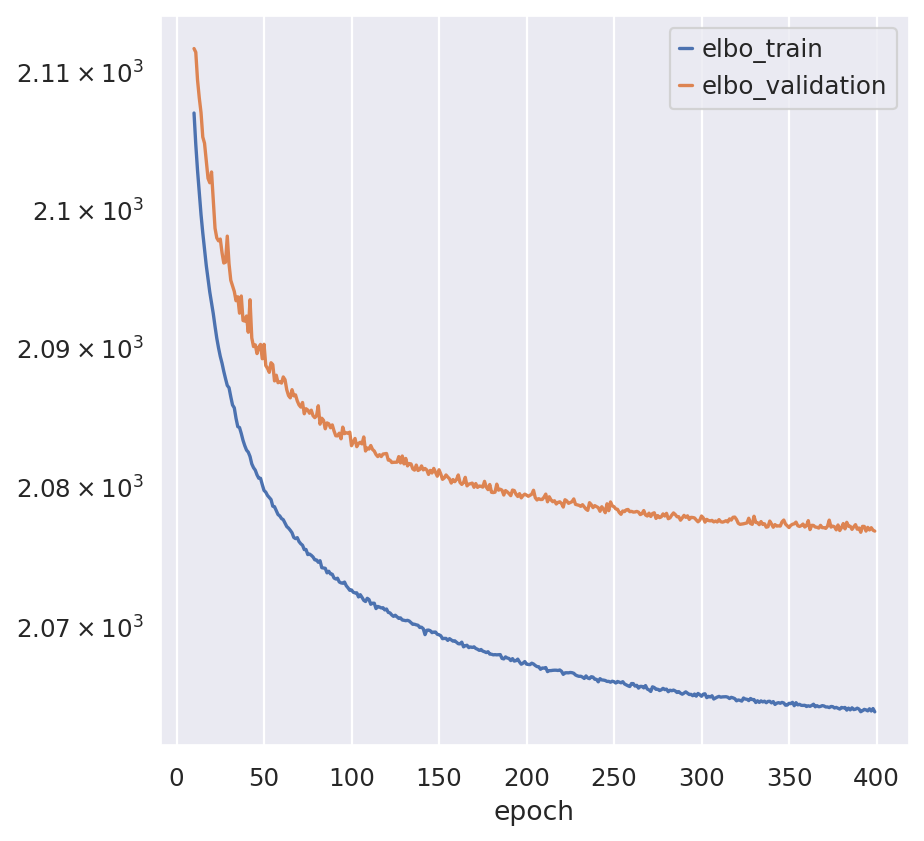

In [10]:
# Ensure convergence
train_test_results = model.history["elbo_train"]
train_test_results["elbo_validation"] = model.history["elbo_validation"]
train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
plt.show()

### Get the latent space and compute UMAP

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


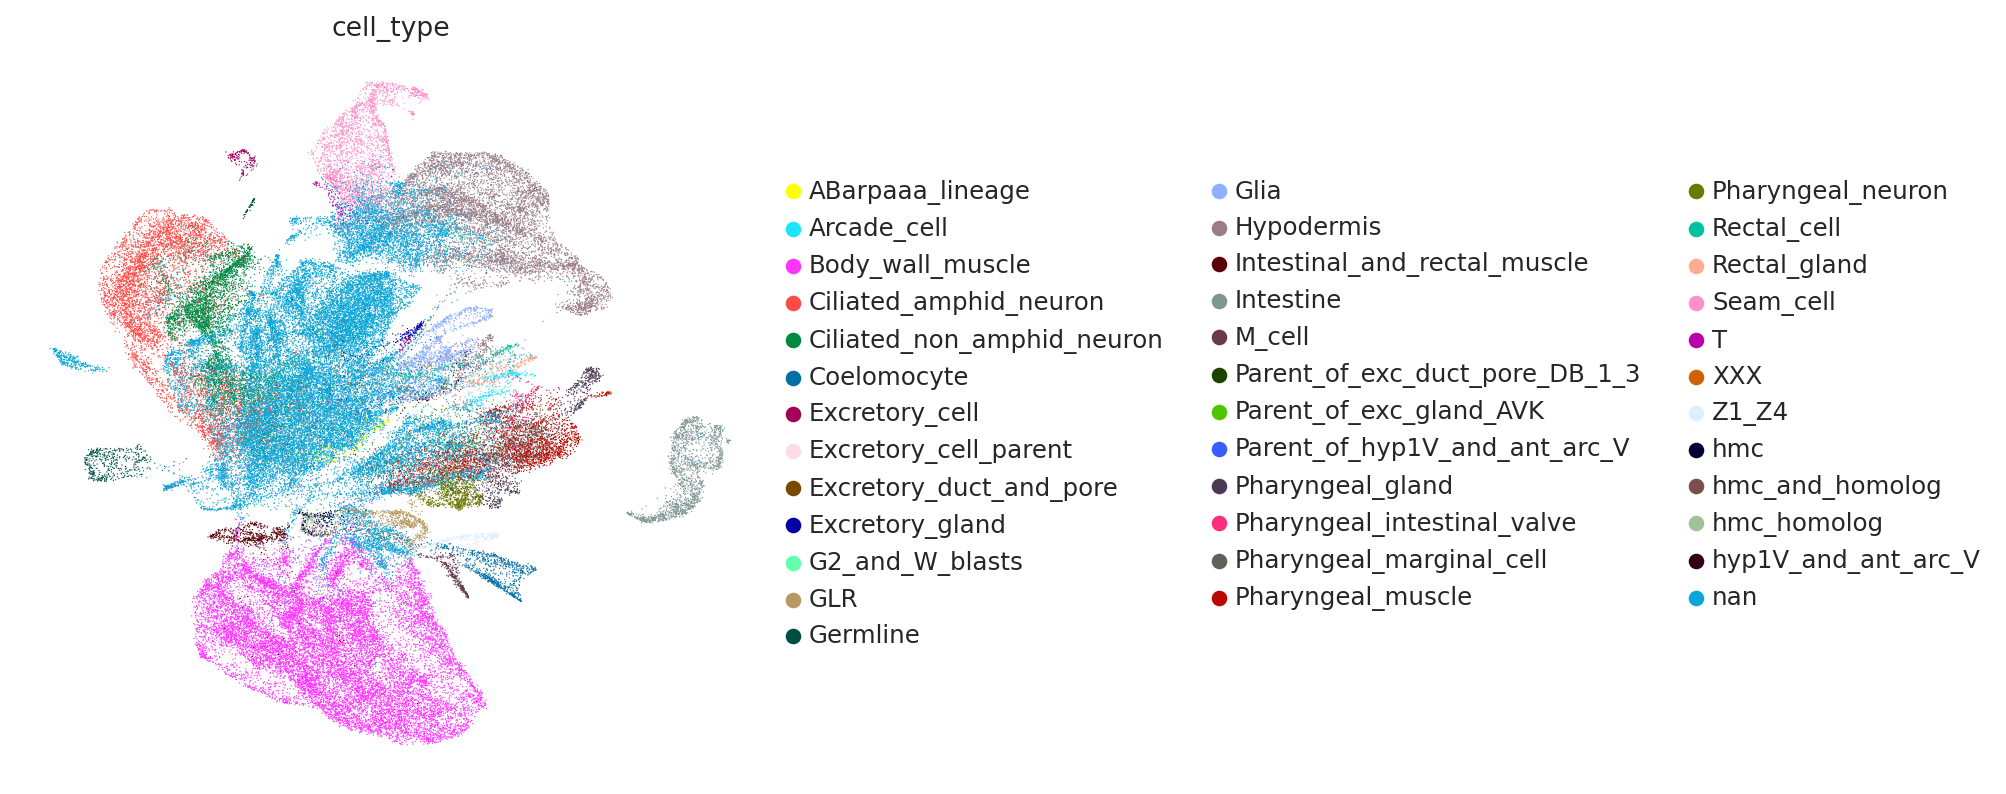

In [11]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata)
sc.pl.umap(adata, color="cell_type")

## Performing Differential Expression in scVI

Differential expression (DE) analysis is used to quantify the differences in gene expression across subpopulations of genes.
If we have two sets of cells $A$ and $B$, a DE test is typically used to predict two things for each gene:

1. Whether the gene's expression levels are significantly different in the A and B sets of cells.
1. An effect size that quantifies the strength of the differential expression.

Once trained, scVI can natively perform both of these tasks.
Additionally, its differential expression module can account for batch effects and filter DE genes expected to be of little relevance.

### Selecting cell subpopulations to compare

In [12]:
# let's take a look at abundances of different cell types
adata.obs["cell_type"].value_counts()

cell_type
nan                               35052
Body_wall_muscle                  17520
Hypodermis                         7746
Ciliated_amphid_neuron             6090
Ciliated_non_amphid_neuron         4468
Seam_cell                          2766
Pharyngeal_muscle                  2562
Glia                               1857
Intestine                          1732
Pharyngeal_neuron                  1471
Pharyngeal_marginal_cell            911
Coelomocyte                         787
Pharyngeal_gland                    786
GLR                                 768
Intestinal_and_rectal_muscle        568
Germline                            499
Pharyngeal_intestinal_valve         493
Arcade_cell                         434
Z1_Z4                               372
Rectal_cell                         327
M_cell                              315
ABarpaaa_lineage                    273
Rectal_gland                        265
Excretory_cell                      215
Excretory_gland               

scVI provides several options to identify the two populations of interest.

In [13]:
cell_type_1 = "Ciliated_non_amphid_neuron"
cell_idx1 = adata.obs["cell_type"] == cell_type_1
print(sum(cell_idx1), "cells of type", cell_type_1)

cell_type_2 = "Intestine"
cell_idx2 = adata.obs["cell_type"] == cell_type_2
print(sum(cell_idx2), "cells of type", cell_type_2)

# or equivalently, provide a string of the form "my_celltype_column == 'desired_celltype'"
# cell_idx1 = "cell_type == 'Ciliated_non_amphid_neuron'"
# cell_idx2 = "cell_type == 'Intestine'"

4468 cells of type Ciliated_non_amphid_neuron
1732 cells of type Intestine


### Basic principle

#### DE and log fold-changes

scVI can natively be used to perform differential expression analyses to compare populations of cells, as described [here](https://doi.org/10.1101/794289) and [there](https://doi.org/10.1101/2022.05.27.493625).
It achieves this by estimating the posterior distribution of the log fold-change (LFC) between subpopulations $A$ and $B$.
Specifically, for a given gene g, scVI calculates the LFC as the difference between the logarithm of its expression level in population A, denoted by $h_g^A$, and the logarithm of its expression level in population B, denoted by $h_g^B$.

The resulting value, denoted by $\beta_g$, provides insights into the expression patterns of gene $g$.
Values close to zero indicate that the gene is expressed similarly in both populations, positive values suggest upregulation in population A and negative values indicate downregulation in population A. This information can be used to better understand the biological mechanisms underlying the differences between the two cell populations.

#### DE testing

In addition to estimating the LFC, scVI can also detect which genes have *significant* expression patterns.
To tag which genes are differentially expressed, scVI tests the following competing hypotheses
$M_{1, g}: \beta_g \in [-\delta, \delta]$ and $M_{2, g}: \beta_g \in (-\infty, -\delta) \cup (\delta, \infty)$.
Here, $\delta$ denotes a small LFC threshold, such that $\beta_g \in [-\delta, \delta]$ is evidence that the gene is equally expressed in the two subpopulations.

Differentially expressed genes are identified by computing the posterior probability of $M_{2, g}$.

### Running DE analyses

#### Running and understanding a DE run

A simple DE analysis can then be performed using the following command

In [14]:
de_change = model.differential_expression(idx1=cell_idx1, idx2=cell_idx2)
de_change

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

DE...: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

DE...: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
index,,,,,,,,,,,,,,,,,,,
WBGene00006870,1.0000,0.0000,18.420681,0.000400,0.000004,0.0,0.25,7.165903,7.197666,1.520534,-1.765389,12.305556,0.567147,0.028291,0.252686,0.025982,5.500196,0.044442,True
WBGene00011938,1.0000,0.0000,18.420681,0.000013,0.000480,0.0,0.25,-5.446735,-5.540369,1.405468,-9.422789,1.125211,0.011638,3.357980,0.010072,0.834873,0.128841,4.526570,True
WBGene00013560,0.9998,0.0002,8.516943,0.000038,0.001268,0.0,0.25,-4.677629,-4.729869,1.584986,-9.786007,2.483212,0.035586,8.210736,0.030886,0.898961,0.340279,12.123684,True
WBGene00011121,0.9998,0.0002,8.516943,0.001431,0.000006,0.0,0.25,7.113941,7.609168,2.303849,-1.747072,12.854574,1.442006,0.040416,0.537601,0.038684,14.994382,0.059873,True
WBGene00000452,0.9998,0.0002,8.516943,0.000240,0.000005,0.0,0.25,5.858909,5.913099,1.573072,-1.599674,11.946387,0.376680,0.033487,0.123545,0.027136,3.191612,0.074427,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBGene00022044,0.5808,0.4192,0.326058,0.000182,0.000167,0.0,0.25,0.164114,0.127701,0.512683,-1.325256,3.128280,0.189124,1.164550,0.163608,0.618938,1.599760,1.586375,False
WBGene00044608,0.5746,0.4254,0.300644,0.000109,0.000094,0.0,0.25,0.215397,0.201292,0.418493,-1.350334,2.464341,0.146599,0.693418,0.123545,0.452079,1.315090,0.948504,False
WBGene00022702,0.5600,0.4400,0.241162,0.000062,0.000062,0.0,0.25,0.000142,-0.035827,0.532482,-1.729041,3.303222,0.075649,0.457272,0.068039,0.340647,0.639998,0.621169,False


This method returns a pandas DataFrame, where each row corresponds to a gene.
The most important columns of this dataframe are the following.
**proba_de**, which captures the posterior probability of $M_{2, g}$ that the gene is differentially expressed. Values close to one indicate that the gene is DE;
**lfc_mean** and **lfc_median**, respectively denoting the mean and the median of the posterior distribution of $\beta_g$. Positive values of the LFC signify that the gene is upregulated in `idx1`;
**is_de_fdr_0.05** is `True` when the gene is tagged DE after FDR correction at target level $\alpha=0.05$. The target level can be adjusted by specifying `fdr_target` in the `differential_expression` method.

#### Main hyperparameters

Additional parameters can be tuned in specific applications.

1. **weights**, which can correspond to <span style="color:#eb5e34">"uniform"</span> or <span style="color:#eb5e34">"importance"</span> specify how normalized gene expressions in the two subpopulations are computed. The <span style="color:#eb5e34">"importance"</span> flavor is specifically designed to provide FDR-calibrated gene sets, but may be overkill if you only aim to rank genes (via their LFC for instance).
1. **filter_outlier_cells** filters out outlier cells prior to computing normalized gene expressions. It is important to set this parameter to `True` when `weights='importance'`.
1. **delta** allows to specify $\delta$, which is used to detect differentially expressed genes. It can also be set automatically using `delta=None`
1. **pseudocounts**, which is zero by default, but can be set to a small value (e.g., 1e-6) when many detected DE genes are seldom expressed in the compared populations.
1. **batch_correction**, which should be set to `True` to account for batch effects. This only makes sense when `idx1` and `idx2` denote cells coming from overlapping batches.

The exact function of these parameters is described [here](https://doi.org/10.1101/2022.05.27.493625).

### Volcano plot of change mode DE with p-values

In [15]:
de_change_uniform = model.differential_expression(
    idx1=cell_idx1,  # we use the same cells as chosen before
    idx2=cell_idx2,
    weights="uniform",
    batch_correction=True,
)

# manipulate the DE results for plotting
de_change_uniform["log10_pscore"] = np.log10(de_change_uniform["proba_not_de"])
de_change_uniform = de_change_uniform.join(adata.var, how="inner")
de_change_uniform.head()

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

DE...: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

DE...: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

/env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,log10_pscore,gene_id,gene_name,gene_description,highly_variable,observed_fraction_zeros,expected_fraction_zeros,prob_zero_enriched_nbatches,prob_zero_enrichment,prob_zero_enrichment_rank
index,,,,,,,,,,,,,,,,,,,,,
WBGene00018727,1.0000,0.0000,18.420681,0.001506,0.000004,0.0,0.25,8.083410,8.553434,2.452872,...,-inf,WBGene00018727,jbts-14,Is involved in non-motile cilium assembly. Loc...,True,0.923044,0.843094,1,0.1451,18051.0
WBGene00004372,1.0000,0.0000,18.420681,0.000978,0.000005,0.0,0.25,7.747259,7.895372,1.346017,...,-inf,WBGene00004372,rig-5,Is an ortholog of human LSAMP (limbic system a...,True,0.928574,0.814163,1,0.1740,18667.0
WBGene00007266,1.0000,0.0000,18.420681,0.000556,0.000012,0.0,0.25,5.491581,5.608122,1.399333,...,-inf,WBGene00007266,C03A3.1,Is enriched in nervous system and pharynx base...,True,0.714697,0.654044,1,0.2390,19470.0
WBGene00007119,1.0000,0.0000,18.420681,0.000597,0.000009,0.0,0.25,5.797742,5.903028,1.622160,...,-inf,WBGene00007119,calf-1,"Is involved in several processes, including de...",True,0.832276,0.797743,1,0.1644,18475.0
WBGene00043097,0.9998,0.0002,8.516543,0.000014,0.000153,0.0,0.25,-3.516246,-3.542899,0.972021,...,-3.698796,WBGene00043097,C02D5.4,Is an ortholog of human GSTO1 (glutathione S-t...,True,0.919165,0.881716,1,0.1124,17138.0


In [16]:
de_change_importance = model.differential_expression(
    idx1=cell_idx1,  # we use the same cells as chosen before
    idx2=cell_idx2,
    weights="importance",
    filter_outlier_cells=True,
    batch_correction=True,
)

# manipulate the DE results for plotting
de_change_importance["log10_pscore"] = np.log10(de_change_importance["proba_not_de"])
de_change_importance = de_change_importance.join(adata.var, how="inner")

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

DE...: 100%|██████████| 1/1 [00:52<00:00, 52.94s/it]

DE...: 100%|██████████| 1/1 [00:52<00:00, 52.94s/it]

/env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


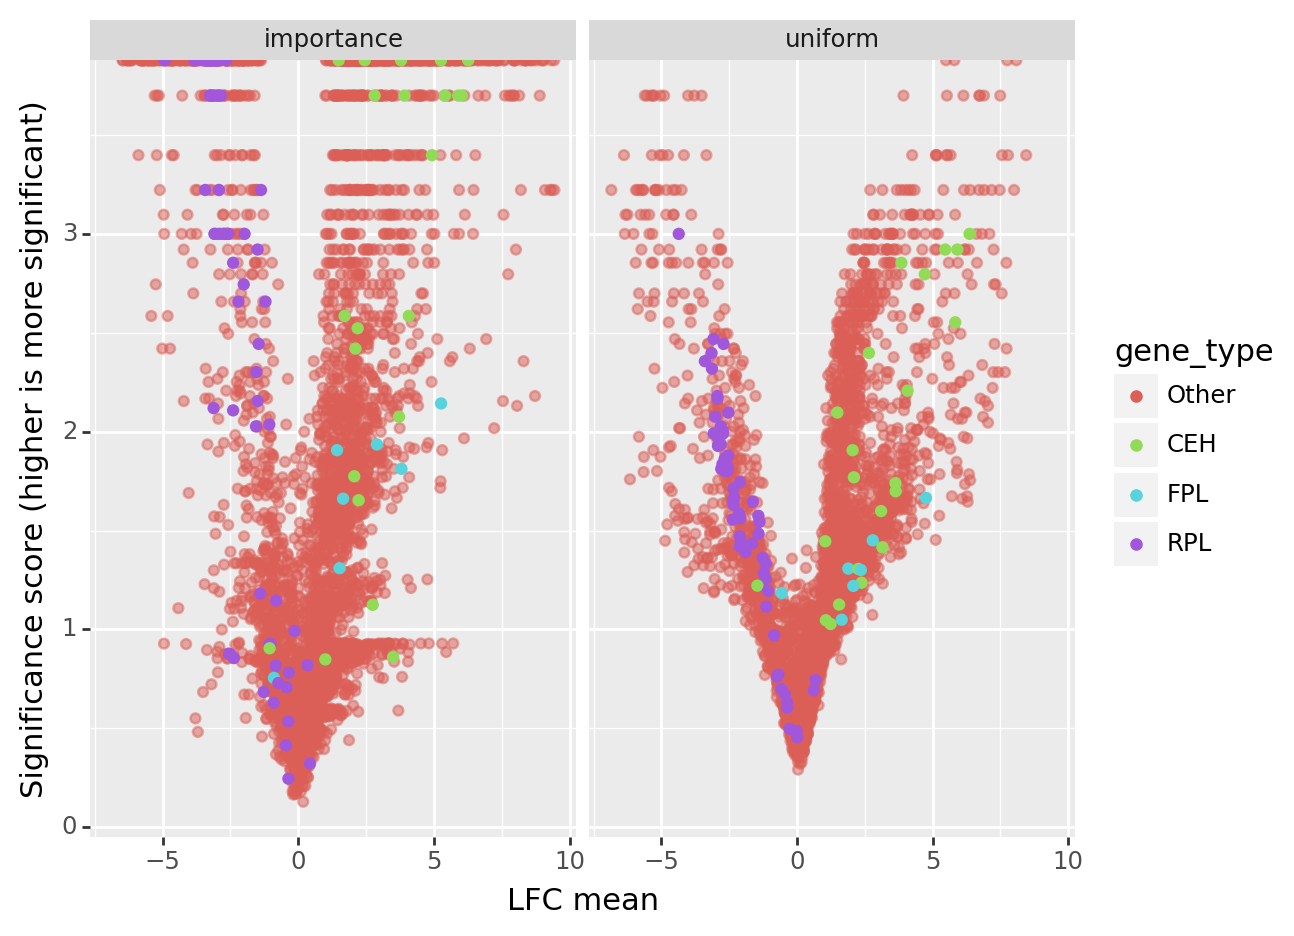

<Figure Size: (640 x 480)>

In [17]:
de_comp = pd.concat(
    [
        de_change_importance.assign(flavor="importance"),
        de_change_uniform.assign(flavor="uniform"),
    ]
)
de_comp["gene_type"] = "Other"
de_comp.loc[lambda x: x["gene_name"].str.contains("rpl-"), "gene_type"] = "RPL"
de_comp.loc[lambda x: x["gene_name"].str.contains("ceh-"), "gene_type"] = "CEH"
de_comp.loc[lambda x: x["gene_name"].str.contains("flp-"), "gene_type"] = "FPL"

(
    p9.ggplot(de_comp, p9.aes("lfc_mean", "-log10_pscore", color="gene_type"))
    + p9.geom_point(
        de_comp.query("gene_type == 'Other'"), alpha=0.5
    )  # Plot other genes with transparence
    + p9.geom_point(de_comp.query("gene_type != 'Other'"))
    + p9.labs(x="LFC mean", y="Significance score (higher is more significant)")
    + p9.facet_wrap("flavor")
)

Contrary to the `uniform` flavor, the `importance` flavor returns sharper posterior probability scores (posterior probability near 0 or 1, respectively in case of equal expression or differential expression).

### Heatmap of top expressed genes

Now we perform DE between each cell type vs all other cells and make a heatmap of the result.

In [18]:
# here we do a 1-vs-all DE test, which compares each cell type with all others
# this returns the concatenation of all 1vsall results, contained in a DataFrame
change_per_cluster_de = model.differential_expression(groupby="cell_type")

DE...:   0%|          | 0/37 [00:00<?, ?it/s]

DE...:   3%|▎         | 1/37 [00:03<02:16,  3.79s/it]

DE...:   5%|▌         | 2/37 [00:07<02:10,  3.73s/it]

DE...:   8%|▊         | 3/37 [00:11<02:04,  3.67s/it]

DE...:  11%|█         | 4/37 [00:14<02:01,  3.67s/it]

DE...:  14%|█▎        | 5/37 [00:18<01:57,  3.68s/it]

DE...:  16%|█▌        | 6/37 [00:22<01:54,  3.69s/it]

DE...:  19%|█▉        | 7/37 [00:25<01:50,  3.70s/it]

DE...:  22%|██▏       | 8/37 [00:29<01:47,  3.71s/it]

DE...:  24%|██▍       | 9/37 [00:33<01:44,  3.72s/it]

DE...:  27%|██▋       | 10/37 [00:37<01:40,  3.72s/it]

DE...:  30%|██▉       | 11/37 [00:40<01:36,  3.73s/it]

DE...:  32%|███▏      | 12/37 [00:44<01:33,  3.73s/it]

DE...:  35%|███▌      | 13/37 [00:48<01:29,  3.73s/it]

DE...:  38%|███▊      | 14/37 [00:52<01:26,  3.75s/it]

DE...:  41%|████      | 15/37 [00:55<01:21,  3.72s/it]

DE...:  43%|████▎     | 16/37 [00:59<01:18,  3.73s/it]

DE...:  46%|████▌     | 17/37 [01:03<01:14,  3.75s/it]

DE...:  49%|████▊     | 18/37 [01:07<01:11,  3.78s/it]

DE...:  51%|█████▏    | 19/37 [01:10<01:08,  3.80s/it]

DE...:  54%|█████▍    | 20/37 [01:14<01:04,  3.80s/it]

DE...:  57%|█████▋    | 21/37 [01:18<01:00,  3.80s/it]

DE...:  59%|█████▉    | 22/37 [01:22<00:57,  3.82s/it]

DE...:  62%|██████▏   | 23/37 [01:26<00:53,  3.82s/it]

DE...:  65%|██████▍   | 24/37 [01:30<00:50,  3.85s/it]

DE...:  68%|██████▊   | 25/37 [01:33<00:46,  3.83s/it]

DE...:  70%|███████   | 26/37 [01:37<00:42,  3.86s/it]

DE...:  73%|███████▎  | 27/37 [01:41<00:38,  3.89s/it]

DE...:  76%|███████▌  | 28/37 [01:45<00:35,  3.91s/it]

DE...:  78%|███████▊  | 29/37 [01:49<00:31,  3.91s/it]

DE...:  81%|████████  | 30/37 [01:53<00:27,  3.93s/it]

DE...:  84%|████████▍ | 31/37 [01:57<00:23,  3.94s/it]

DE...:  86%|████████▋ | 32/37 [02:01<00:19,  3.95s/it]

DE...:  89%|████████▉ | 33/37 [02:05<00:15,  3.95s/it]

DE...:  92%|█████████▏| 34/37 [02:09<00:11,  3.96s/it]

DE...:  95%|█████████▍| 35/37 [02:13<00:07,  3.96s/it]

DE...:  97%|█████████▋| 36/37 [02:17<00:03,  3.96s/it]

DE...: 100%|██████████| 37/37 [02:21<00:00,  3.89s/it]

DE...: 100%|██████████| 37/37 [02:21<00:00,  3.82s/it]

We focus on cell-types with at least 500 cells, and which have annotations to facilitate heatmap visualization

In [19]:
cell_types = (
    adata.obs["cell_type"]
    .value_counts()
    # .loc[lambda x: (x >= 500) & (x.index != "nan")]
    .loc[lambda x: x.index != "nan"]
    .to_frame("n_cells")
)
cell_types.loc[:, "associated_test"] = cell_types.index.astype(str) + " vs Rest"

In [20]:
# This cell extracts list of top 5 upregulated genes for every cell-type
marker_genes = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False).iloc[:5]
    )  # Select top 5 DE genes per comparison
    .reset_index(drop=True)["index"]
    .unique()
)

/tmp/ipykernel_157/3695070939.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


/env/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/env/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/env/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


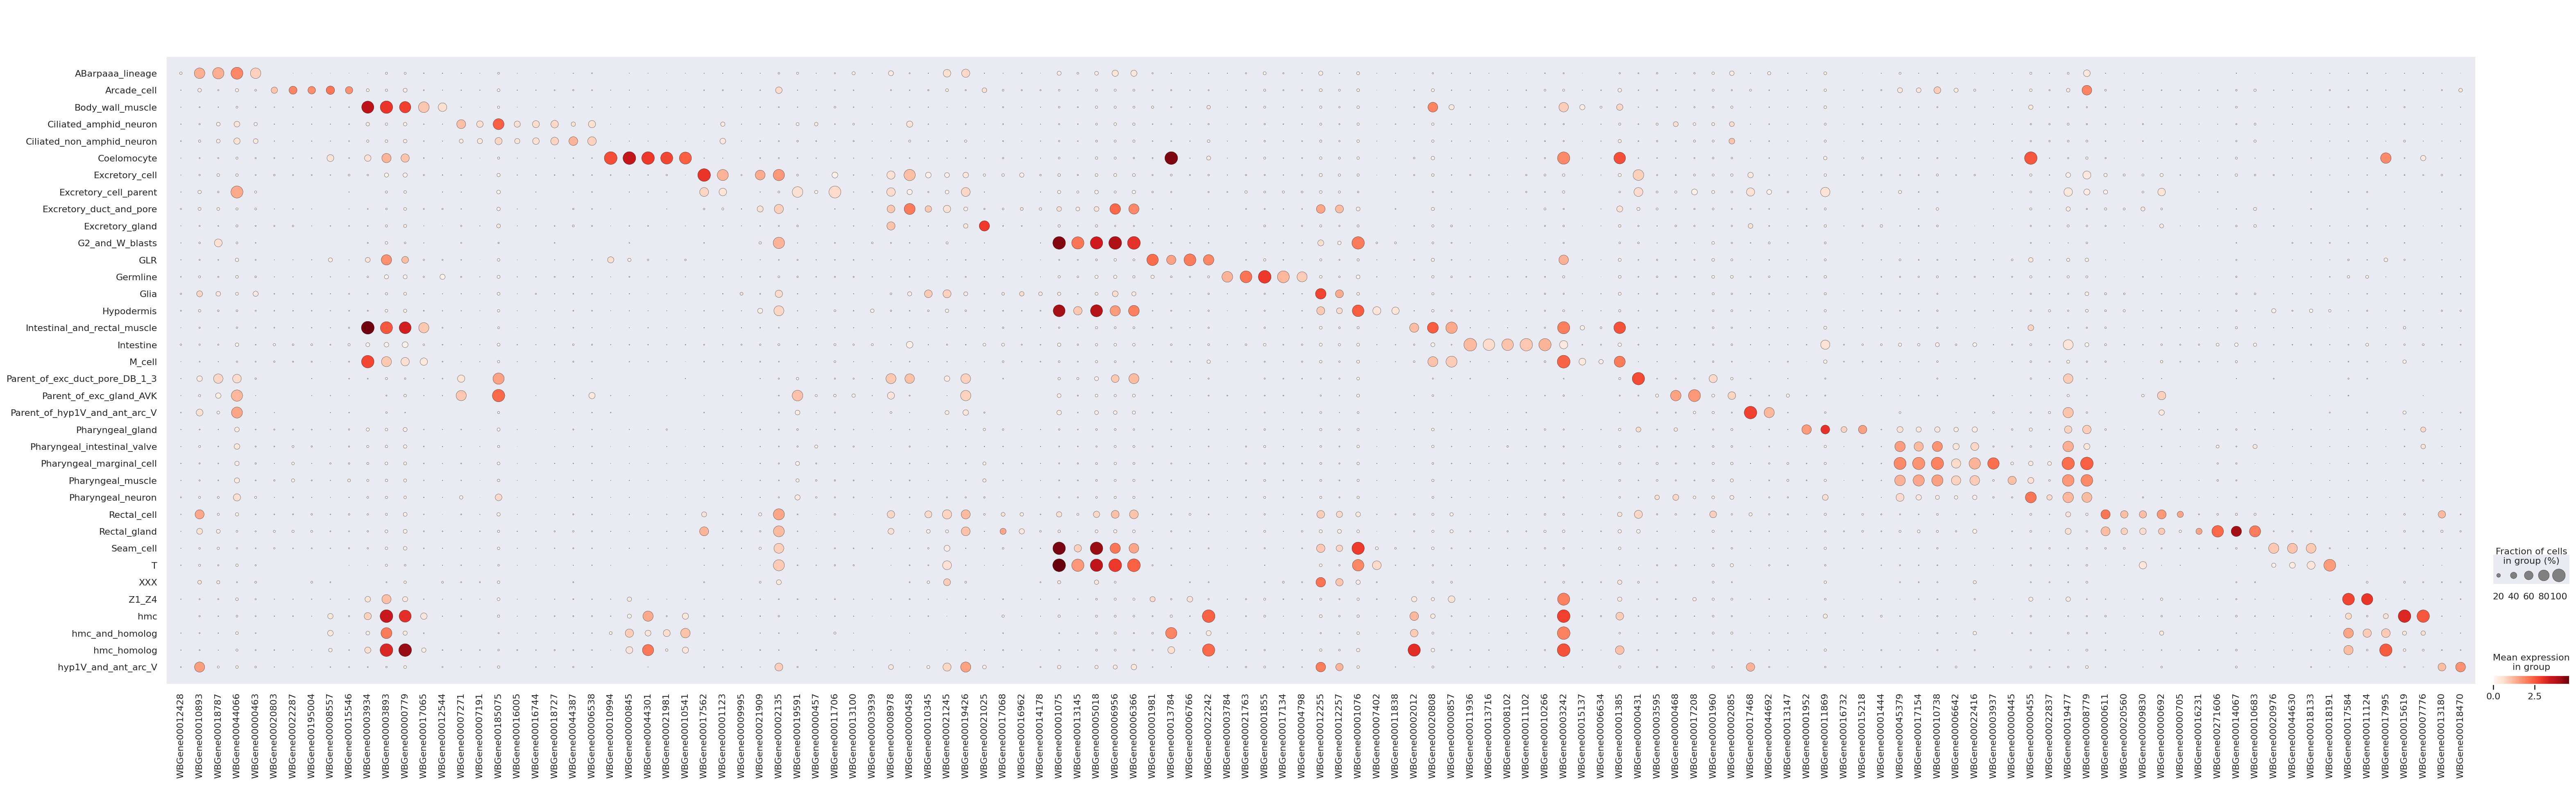

In [21]:
adata_log = adata[adata.obs.cell_type.isin(cell_types.index.values)].copy()
sc.pp.normalize_total(adata_log)
sc.pp.log1p(adata_log)
sc.pl.dotplot(adata_log, marker_genes, groupby="cell_type")